In [1]:
! pip install sqlalchemy
! pip install shap

Цель: создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Важно:

- тип виновника — только машина (car);
- любым повреждениям транспортного средства, кроме типа SCRATCH (царапина);
- ограничиться данными за 2012 год — они самые свежие;
- учесть фактор возраста автомобиля.

# Импорты и константы

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import os
import requests
import phik
from phik import resources, report
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
     f1_score,
     confusion_matrix,
     roc_auc_score,
     roc_curve
)
from scipy import stats as st
import missingno

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import *

from time import time

from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score
)
import shap
import optuna
from tqdm import tqdm

RANDOM_STATE = 1220

# Первичное исследование таблиц

In [3]:
def info_df(df):
    print('------------------------------')
    print('| Информация о наборе данных |')
    print('------------------------------')
    df.info()
    print('-----------------------------------------')
    print('| Первые и последние 5 строчек датасета |')
    print('-----------------------------------------')
    display(df)
    print('--------------------')
    print('| Сумма дубликатов |')
    print('--------------------')
    print(df.duplicated().sum())
    for i in df.select_dtypes(include='object').columns.to_list():
        print('--------------------------------------')
        print(f'| Уникальные значения признака {i} |')
        print('--------------------------------------')
        print(df[i].unique())


def view_distribution(data):
    interval_cols = data.select_dtypes(include='object').columns.to_list()
    fig, axes = plt.subplots(nrows=len(data[interval_cols].columns), ncols=2, figsize=(15, 15))
    j = 0
    for i in data[interval_cols].columns:
        sns.histplot(data[interval_cols][i], ax=axes[j, 0], kde=True, bins=40, edgecolor='black', color=sns.color_palette("pink")[0])
        axes[j, 0].set_title(i, fontsize=14)
        axes[j, 0].set_xlabel('')

        sns.boxplot(x=data[interval_cols][i], ax=axes[j, 1], orient='h', palette="pink")
        axes[j, 1].set_title(i, fontsize=14)
        axes[j, 1].set_xlabel('')
        j += 1

    plt.suptitle(f'Признаки\n\n', ha='center', fontweight='bold', fontsize=20)
    plt.tight_layout()
    plt.show()


def phik_sign(data):
    interval_cols = data.select_dtypes(exclude='object').columns.to_list()
    phik_overview = data.phik_matrix(interval_cols=interval_cols)

    plt.figure(figsize=(10, 10))
    plt.title(r'Корреляция $\phi_K$')
    corr = phik_overview.round(2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=.3, center=0,
            annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

    significance_overview  = data.significance_matrix(interval_cols=interval_cols)

    plt.figure(figsize=(10, 10))
    plt.title('Статистическая значимость')
    corr = significance_overview.round(2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=5, vmin=-5, center=0,
            annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()

In [4]:

db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

**Таблица parties**

In [5]:
sql_parties = """
SELECT  *
FROM parties
"""

info_df(pd.read_sql_query(sql_parties, con=engine, index_col='id'))

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2752408 entries, 22 to 2403844
Data columns (total 8 columns):
 #   Column               Dtype  
---  ------               -----  
 0   case_id              object 
 1   party_number         int64  
 2   party_type           object 
 3   at_fault             int64  
 4   insurance_premium    float64
 5   party_sobriety       object 
 6   party_drug_physical  object 
 7   cellphone_in_use     float64
dtypes: float64(2), int64(2), object(4)
memory usage: 189.0+ MB
-----------------------------------------
| Первые и последние 5 строчек датасета |
-----------------------------------------


,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
id,,,,,,,,
22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
29,3899462,2,car,0,21.0,had not been drinking,None,0.0
31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
...,...,...,...,...,...,...,...,...
1549682,4981212,2,building,0,22.0,had not been drinking,None,NaN
1644472,5041069,2,building,0,13.0,had not been drinking,None,0.0
1906386,5181692,1,building,1,5.0,had not been drinking,None,0.0


--------------------
| Сумма дубликатов |
--------------------
0
--------------------------------------
| Уникальные значения признака case_id |
--------------------------------------
['3899454' '3899462' '3899465' ... '5456653' '5456655' '4770406']
--------------------------------------
| Уникальные значения признака party_type |
--------------------------------------
['road signs' 'car' 'road bumper' None 'building' 'other']
--------------------------------------
| Уникальные значения признака party_sobriety |
--------------------------------------
['had not been drinking' 'not applicable' 'impairment unknown' None
 'had been drinking, not under influence'
 'had been drinking, under influence'
 'had been drinking, impairment unknown']
--------------------------------------
| Уникальные значения признака party_drug_physical |
--------------------------------------
[None 'not applicable' 'G' 'under drug influence' 'sleepy/fatigued'
 'impairment - physical']


In [6]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
(pd.DataFrame(round(pd.read_sql_query(sql_parties, con=engine, index_col='id')
.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
case_id,0.000000
party_number,0.000000
party_type,0.100000
at_fault,0.000000
insurance_premium,14.700000
party_sobriety,2.700000
party_drug_physical,84.300000
cellphone_in_use,18.600000


| Описание                                                     | Обозначение в таблице | Подробнее                                                    |
|:------------------------------------------------------------ |:--------------------- |:------------------------------------------------------------ |
| Идентификационный номер                                      | ID                    | Уникальный идентификатор                                                                          |
| Идентификационный номер в базе данных                        | CASE_ID               | Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
| Номер участника происшествия                                 | PARTY_NUMBER          | От 1 до N — по числу участников происшествия                 |
| Тип участника происшествия                                   | PARTY_TYPE            | 1 — Car (Авто)<br />2 — Road bumper (Дорожные знаки)<br />3 — Building (Строения)<br />4 — Road signs (Отбойник)<br />5 — Other (Другое)<br />6 — Operator (Оператор)<br />- — Not Stated (Не указано) |
| Виновность участника                                         | AT_FAULT              | 0/1                                                          |
| Сумма страховки (тыс. $)                                     | INSURANCE_PREMIUM     | число                                                        |
| Состояние участника: физическое или с учётом принятых лекарств | PARTY_DRUG_PHYSICAL   | E — Under Drug Influence (Под воздействием лекарств)<br />F — Impairment — Physical (Ухудшение состояния)<br />G — Impairment Unknown (Не известно)<br />H — Not Applicable (Не оценивался)<br />I — Sleepy/Fatigued (Сонный/Усталый)<br />- — Not Stated (Не указано) |
| Трезвость участника                                          | PARTY_SOBRIETY        | A — Had Not Been Drinking (Не пил)<br />B — Had Been Drinking, Under Influence (Был пьян, под влиянием)<br />C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием)<br />D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно)<br />G — Impairment Unknown (Неизвестно ухудшение)<br />H — Not Applicable (Не оценивался)<br />- — Not Stated (Не указано) |
| Наличие телефона в автомобиле (возможности разговаривать по громкой связи) | CELLPHONE_IN_USE      | 0/1                                                          |

В таблице `parties` есть несоответсвие данных, те данные которые должны быть записаны как целые числа или в виде буквенных обозначений, записаны в полном пояснении, при этом не все варианты есть, и существует большое количество пропусков данных особенно в физическом состоянии участника проишествия

**Таблица collisions**

In [7]:
sql_collisions = """
SELECT *
FROM collisions
"""

info_df(pd.read_sql_query(sql_collisions, con=engine, index_col='case_id'))

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 1400000 entries, 4083072 to 4083051
Data columns (total 19 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   county_city_location         1400000 non-null  object 
 1   county_location              1400000 non-null  object 
 2   distance                     1400000 non-null  float64
 3   direction                    1059358 non-null  object 
 4   intersection                 1387781 non-null  float64
 5   weather_1                    1392741 non-null  object 
 6   location_type                518779 non-null   object 
 7   collision_damage             1400000 non-null  object 
 8   party_count                  1400000 non-null  int64  
 9   primary_collision_factor     1391834 non-null  object 
 10  pcf_violation_category       1372046 non-null  object 
 11  type_of_

,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
case_id,,,,,,,,,,,,,,,,,,,
4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4082805,1502,kern,57.0,east,0.0,clear,None,middle damage,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,dark with no street lights,none,2009-01-17,21:04:00
4082820,1953,los angeles,0.0,None,1.0,clear,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,daylight,functioning,2009-01-18,14:20:00
4082829,1502,kern,0.0,None,1.0,clear,highway,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,dark with street lights,functioning,2009-01-17,18:06:00


--------------------
| Сумма дубликатов |
--------------------
158
--------------------------------------
| Уникальные значения признака county_city_location |
--------------------------------------
['1942' '4313' '0109' '1950' '3004' '1500' '3307' '1975' '3300' '3315'
 '5690' '3305' '1971' '3009' '1959' '3012' '1985' '4807' '3801' '3903'
 '1000' '3003' '0112' '3000' '5000' '0105' '3028' '5007' '3017' '4005'
 '4006' '3104' '3313' '5607' '5600' '0100' '5601' '3609' '1900' '1989'
 '3702' '1908' '4200' '1300' '4116' '3001' '0707' '4304' '1925' '0901'
 '1953' '0300' '4806' '3404' '0101' '4311' '5407' '4109' '4300' '0900'
 '5704' '4900' '4905' '4111' '4904' '2406' '4100' '4305' '3013' '3024'
 '3020' '3007' '2300' '4203' '1923' '2900' '2802' '2109' '3106' '3100'
 '5200' '3401' '1941' '3616' '5002' '4306' '4114' '3021' '3008' '3026'
 '3630' '0710' '0701' '3341' '0712' '0706' '3312' '0700' '4008' '3607'
 '4102' '1990' '5500' '1700' '1977' '0709' '1949' '3602' '1901' '1969'
 '1976' '4803' '3010

In [8]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
(pd.DataFrame(round(pd.read_sql_query(sql_collisions, con=engine, index_col='case_id')
.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
county_city_location,0.000000
county_location,0.000000
distance,0.000000
direction,24.300000
intersection,0.900000
weather_1,0.500000
location_type,62.900000
collision_damage,0.000000
party_count,0.000000
primary_collision_factor,0.600000


| Описание                                           | Обозначение в таблице       | Подробнее                                                    |
| :------------------------------------------------- | :-------------------------- | :----------------------------------------------------------- |
| Идентификационный Номер в базе данных              | CASE_ID                     | Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
| Дата происшествия                                  | COLLISION_DATE              | Формат год/месяц/день                                        |
| Время происшествия                                 | COLLISION_TIME              | Формат: 24-часовой                                           |
| Является ли место происшествие перекрёстком        | INTERSECTION                | Y — Intersection (перекрёсток)<br />N — Not Intersection (не перекрёсток)<br />-- — Not stated (Не указано) |
| Погода                                             | WEATHER_1                   | A — Clear (Ясно)<br />B — Cloudy (Облачно)<br />C — Raining (Дождь)<br />D — Snowing (Снегопад)<br />E — Fog (Туман)<br />F — Other (Другое)<br />G — Wind (Ветер)<br />- — Not Stated (Не указано) |
| Серьёзность происшествия                           | COLLISION_DAMAGE            | 1 — FATAL ТС (Не подлежит восстановлению)<br />2 — SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения)<br />3 — MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло)<br />4 — SMALL DAMAGE (Отдельный элемент кузова под замену/покраску)<br />0 – SCRATCH (Царапина) |
| Основной фактор аварии                             | PRIMARY_COLL_FACTOR         | A — Code Violation (Нарушение правил ПДД)<br />B — Other Improper Driving (Другое неправильное вождение)<br />C — Other Than Driver (Кроме водителя)<br />D — Unknown (Неизвестно)<br />E — Fell Asleep (Заснул)<br />- — Not Stated (Не указано) |
| Состояние дороги                                   | ROAD_SURFACE                | A — Dry (Сухая)<br />B — Wet (Мокрая)<br />C — Snowy or Icy (Заснеженная или обледенелая)<br />D — Slippery (Muddy, Oily, etc.) (Скользкая, грязная, маслянистая и т. д.)<br />- — Not Stated (Не указано) |
| Освещение                                          | LIGHTING                    | A — Daylight (Дневной свет)<br />B — Dusk-Dawn (Сумерки-Рассвет)<br />C — Dark-Street Lights (Темно-Уличные фонари)<br />D — Dark-No Street Lights (Темно-Нет уличных фонарей)<br />E — Dark-Street Lights Not Functioning (Темно-Уличные фонари не работают)<br />- — Not Stated (Не указано) |
| Номер географических районов, где произошло ДТП    | COUNTY_CITY_LOCATION        | число                                                        |
| Названия географических районов, где произошло ДТП | COUNTY_LOCATION             | список разных названий, категориальный тип данных            |
| Направление движения на перекрёстке                | DIRECTION                   | N — North (Север)<br />E — East (Восток)<br />S — South (Юг)<br />W — West (Запад)<br />- or blank — Not State (Не указано) |
| Расстояние от главной дороги (метры)               | DISTANCE                    | число                                                        |
| Тип дороги                                         | LOCATION_TYPE               | H — Highway (Шоссе)<br />I — Intersection (Перекрёсток)<br />R — Ramp (or Collector) (Рампа)<br />- or blank — Not State Highway (Не указано) |
| Количество участников                              | PARTY_COUNT                 | число                                                        |
| Категория нарушения                                | PCF_VIOLATION_CATEGORY      | 01 — Driving or Bicycling Under the Influence of Alcohol or Drug (Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения)<br />02 — Impeding Traffic (Препятствие движению транспорта)<br />03 — Unsafe Speed (Превышение скорости)<br />04 — Following Too Closely (Опасное сближение)<br />05 — Wrong Side of Road (Неправильная сторона дороги)<br />06 — Improper Passing (Неправильное движение)<br />07 — Unsafe Lane Change (Небезопасная смена полосы движения)<br />08 — Improper Turning (Неправильный поворот)<br />09 — Automobile Right of Way (Автомобильное право проезда)<br />10 — Pedestrian Right of Way (Пешеходное право проезда)<br />11 — Pedestrian Violation (Нарушение пешеходами)<br />12 — Traffic Signals and Signs (Дорожные сигналы и знаки)<br />13 — Hazardous Parking (Неправильная парковка)<br />14 — Lights (Освещение)<br />15 — Brakes (Тормоза)<br />16 — Other Equipment (Другое оборудование)<br />17 — Other Hazardous Violation (Другие нарушения)<br />18 — Other Than Driver (or Pedestrian) (Кроме водителя или пешехода)<br />19 — Speeding (Скорость)<br />20 — Pedestrian dui (Нарушение пешехода)<br />21 — Unsafe Starting or Backing (Опасный старт)<br />22 — Other Improper Driving (Другое неправильное вождение)<br />23 — Pedestrian or “Other” Under the Influence of Alcohol or Drug (Пешеход или «Другой» в состоянии алкогольного или наркотического опьянения)<br />24 — Fell Asleep (Заснул)<br />00 — Unknown (Неизвестно)<br />- — Not Stated (Не указано) |
| Тип аварии                                         | TYPE_OF_COLLISION           | A — Head-On (Лоб в лоб)<br />B — Sideswipe (Сторона)<br />C — Rear End (Столкновение задней частью)<br />D — Broadside (Боковой удар)<br />E — Hit Object (Удар объекта)<br />F — Overturned (Опрокинутый)<br />G — Vehicle (транспортное средство/ Пешеход)<br />H — Other (Другое)<br />- — Not Stated (Не указано) |
| Дополнительные участники ДТП                       | MOTOR_VEHICLE_INVOLVED_WITH | Other motor vehicle (Другой автомобиль)<br />Fixed object (Неподвижный объект)<br />Parked motor vehicle (Припаркованный автомобиль)<br />Pedestrian (Пешеход)<br />Parked motor vehicle (Припаркованный автомобиль)<br />Bicycle (Велосипедист)<br />Non-collision (Не столкновение)<br />Other object (Другой объект)<br />Motor vehicle on other roadway (Автомобиль на другой проезжей)<br />Animal (Животное)<br />Train (Поезд) |
| Дорожное состояние                                 | ROAD_CONDITION_1            | A — Holes, Deep Ruts (Ямы, глубокая колея)<br />B — Loose Material on Roadway (Сыпучий материал на проезжей части)<br />C — Obstruction on Roadway (Препятствие на проезжей части)<br />D — Construction or Repair Zone (Зона строительства или ремонта)<br />E — Reduced Roadway Width (Уменьшенная ширина проезжей части)<br />F — Flooded (Затоплено)<br />G — Other (Другое)<br />H — No Unusual Condition (Нет ничего необычного)<br />- — Not Stated (Не указано) |
| Устройство управления                              | control_device              | A — Functioning (Функционирует)<br />B — Not Functioning (Не функционирует)<br />C — Obscured (Затемнённый)<br />D — None (Нет)<br />- — Not Stated (Не указано) |

Аналогичная ситуация как и прошлой таблице за исключением признака `motor_vehicle_involved_with`

**Таблица vehicles**

In [9]:
sql_vehicles = """
SELECT *
FROM vehicles
"""
info_df(pd.read_sql_query(sql_vehicles, con=engine, index_col='id'))

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021234 entries, 1175713 to 1175699
Data columns (total 5 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   case_id               1021234 non-null  object 
 1   party_number          1021234 non-null  int64  
 2   vehicle_type          1021234 non-null  object 
 3   vehicle_transmission  997575 non-null   object 
 4   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 46.7+ MB
-----------------------------------------
| Первые и последние 5 строчек датасета |
-----------------------------------------


,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
id,,,,,
1175713,5305032,2,sedan,manual,3.0
1,3858022,1,sedan,auto,3.0
1175712,5305030,1,sedan,auto,3.0
1175717,5305033,3,sedan,auto,5.0
1175722,5305034,2,sedan,auto,5.0
...,...,...,...,...,...
1175684,5304990,2,sedan,manual,6.0
1175686,5304993,2,sedan,manual,3.0
1175687,5304994,2,sedan,manual,3.0


--------------------
| Сумма дубликатов |
--------------------
0
--------------------------------------
| Уникальные значения признака case_id |
--------------------------------------
['5305032' '3858022' '5305030' ... '5304994' '5305002' '5305007']
--------------------------------------
| Уникальные значения признака vehicle_type |
--------------------------------------
['sedan' 'hatchback' 'coupe' 'minivan' 'other']
--------------------------------------
| Уникальные значения признака vehicle_transmission |
--------------------------------------
['manual' 'auto' None]


In [10]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
(pd.DataFrame(round(pd.read_sql_query(sql_vehicles, con=engine, index_col='id')
.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
case_id,0.000000
party_number,0.000000
vehicle_type,0.000000
vehicle_transmission,2.300000
vehicle_age,2.400000


| Описание                              | Обозначение в таблице | Подробнее                                                    |
| :------------------------------------ | :-------------------- | :----------------------------------------------------------- |
| Индекс текущей таблицы                | ID                    | Номер в таблице                                              |
| Идентификационный номер в базе данных | CASE_ID               | Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
| Тип кузова                            | VEHICLE_TYPE          | MINIVAN<br />COUPE<br />SEDAN<br />HATCHBACK<br />OTHER      |
| Тип КПП                               | VEHICLE_TRANSMISSION  | auto (Автоматическая)<br />manual (Ручная)<br />- — Not Stated (Не указано) |
| Возраст автомобиля (в годах)          | VEHICLE_AGE           | число                                                        |

**Таблица case_ids**

In [11]:
sql_case_ids = """
SELECT *
FROM case_ids
"""
info_df(pd.read_sql_query(sql_case_ids, con=engine))

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB
-----------------------------------------
| Первые и последние 5 строчек датасета |
-----------------------------------------


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
...,...,...
1399995,5668365,2021
1399996,5668366,2021
1399997,5668367,2021
1399998,5668368,2021


--------------------
| Сумма дубликатов |
--------------------
0
--------------------------------------
| Уникальные значения признака case_id |
--------------------------------------
['0081715' '0726202' '3858022' ... '5668367' '5668368' '5668369']
--------------------------------------
| Уникальные значения признака db_year |
--------------------------------------
['2021']


In [12]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
(pd.DataFrame(round(pd.read_sql_query(sql_case_ids, con=engine)
.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
case_id,0.000000
db_year,0.000000


Таблица отличается от того, как она описана на схеме данных. В ней 2 столбца:
- case_id - столбец с id проишествия
- db_year - столбец с годом

**Вывод**

Количество таблиц сопадает с заявленым, однако во всех таблицахимеются пропуски в данных и типы данных не соответсвуют заявленым. Связующая таблица case_ids не соответствовала завяленой архитектуре. Записи в таблицах `collisions` и `parties` несогласуются с описанием таблиц. Связующая таблица в столбце `db_year` содержит только одно уникальное значение 2021 года, что он означает не известно, но скорее всего это год создания схемы.

В данных содержится информация связанная исключительно с ДТП, но нет данных которые бы относились к благоприятной поездки, при обучении модель будет всегда смещаться в сторону ДТП из-за дисбаланса.

Общий ключ для всех таблиц - case_id

# Cтатистический анализ факторов ДТП

Посмотри на то в какие месяцы происходит наибольшее количество аварий, а также какой из сезонов был самым частым на ДТП.

In [13]:
sql_q = """
WITH col AS (SELECT COUNT(case_id) AS collision,
                        DATE_TRUNC('month', collision_date)::timestamp AS month,
                        (CASE
                                WHEN EXTRACT(MONTH FROM collision_date) = 12 OR EXTRACT(MONTH FROM collision_date) BETWEEN 1 AND 2 THEN 'winter'
                                WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 3 AND 5 THEN 'spring'
                                WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 6 AND 8 THEN 'summer'
                                WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 9 AND 11 THEN 'autumn'
                        END) AS season
                FROM collisions
                GROUP BY month, season)
SELECT  *,
        SUM(collision) OVER (PARTITION BY season) AS col_season
FROM col;
"""
select = pd.read_sql_query(sql_q, con=engine, parse_dates='month')

In [14]:
select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   collision   56 non-null     int64         
 1   month       56 non-null     datetime64[ns]
 2   season      56 non-null     object        
 3   col_season  56 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.9+ KB


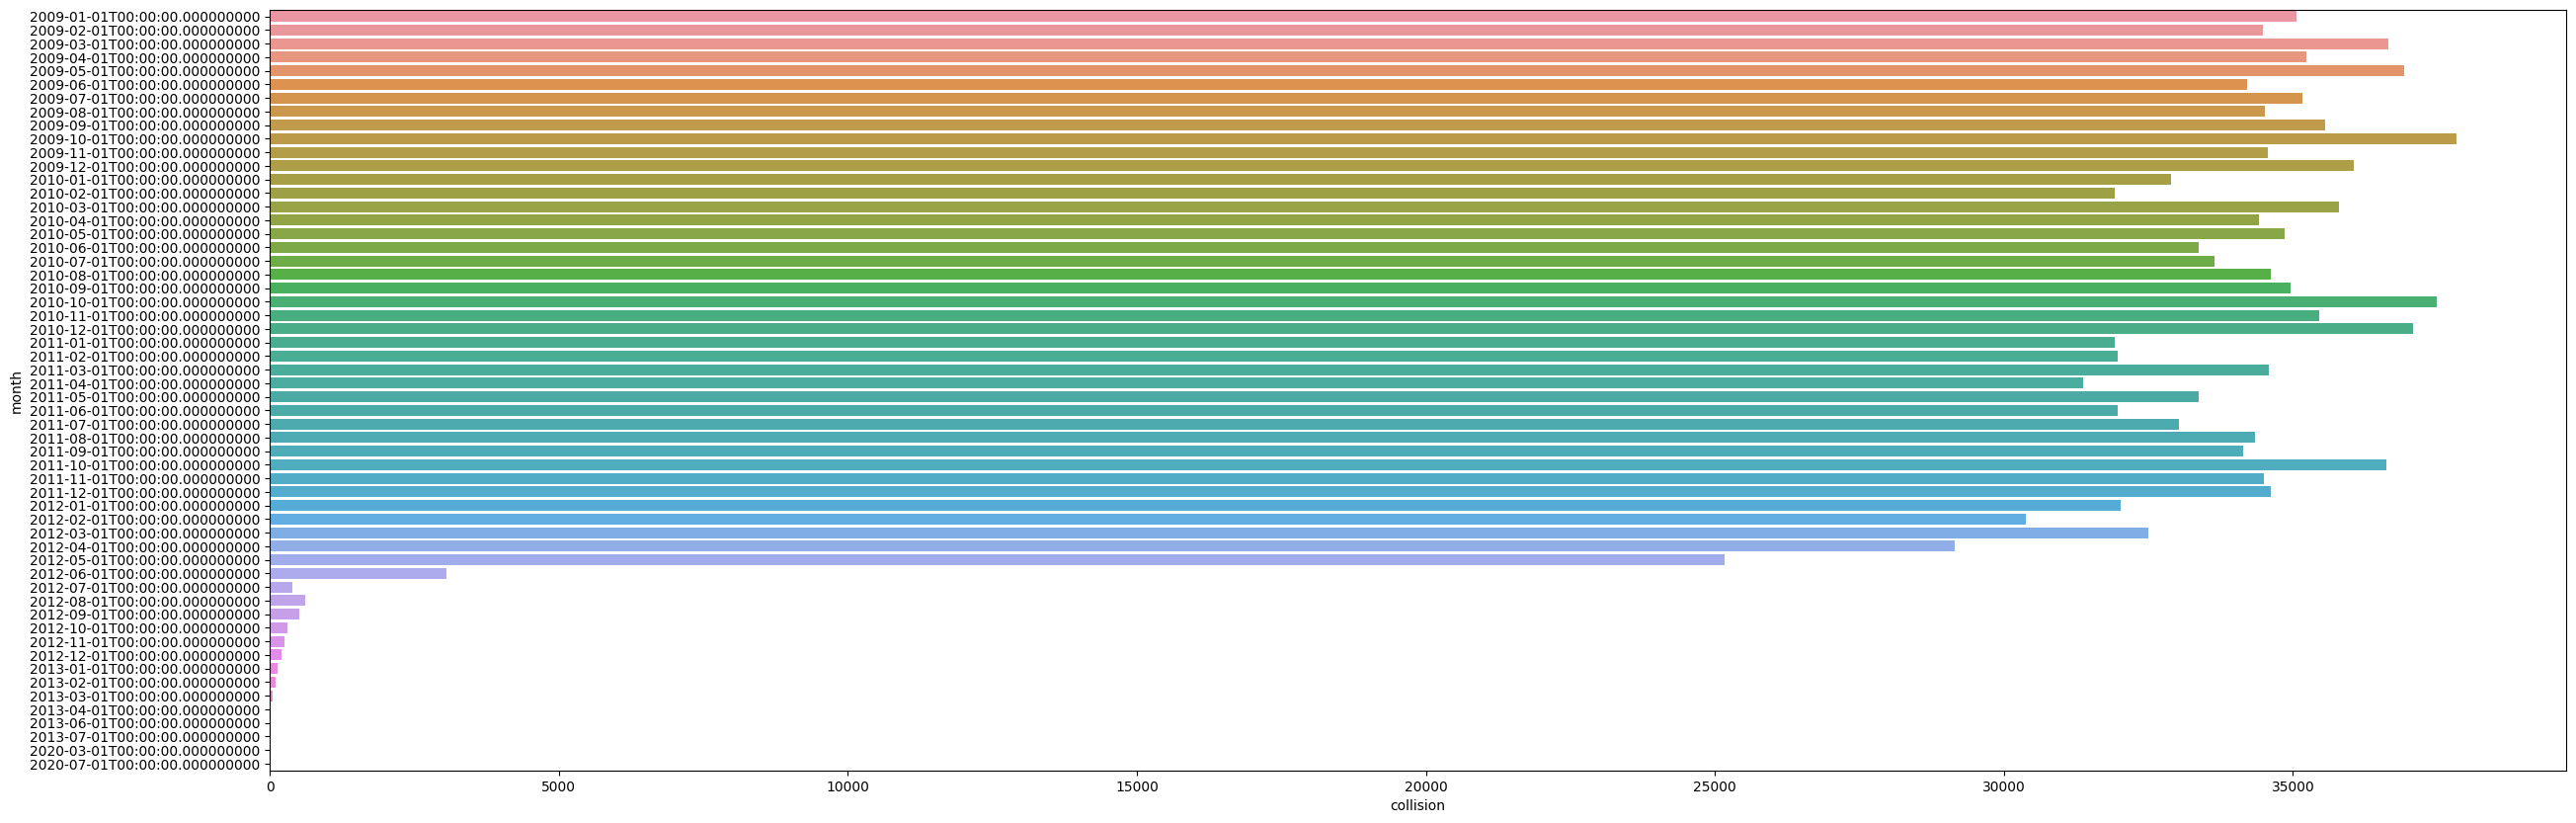

In [15]:
f, ax = plt.subplots(figsize=(30, 10))
sns.barplot(data=select.sort_values(by='month'), y='month', x='collision', ax=ax);

На гистрограмме распределения видно, что начиная со второй половины 2012 года, данных становится сильно меньше, при этом существует разрыв начиная с 2013 года и до 2020. Ниже приведено распределение ДТП по временам года.

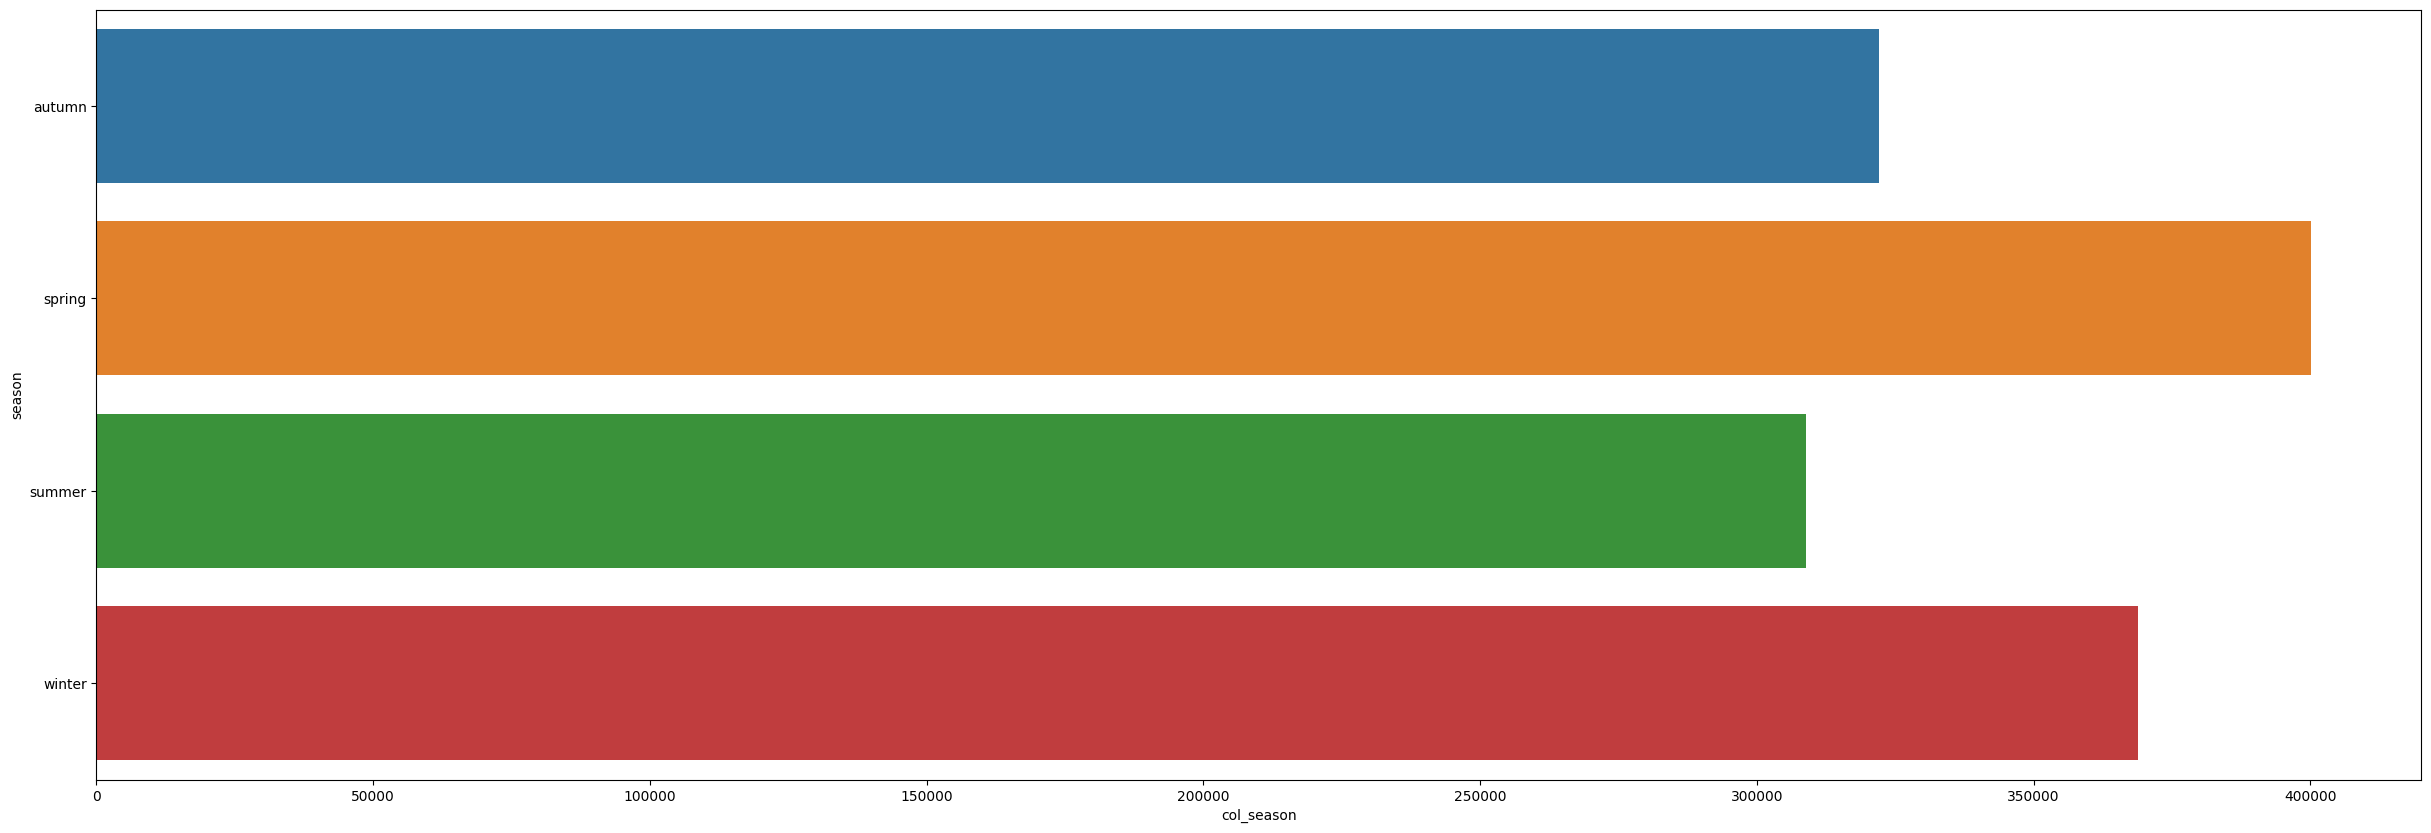

In [16]:
f, ax = plt.subplots(figsize=(30, 10))
sns.barplot(data=select, y='season', x='col_season', ax=ax);

Наиболее опасными сезонами является весна и зима, это можно связать с сильным изменением погодных условий, таких как: температура, давление, количество осадков, скорость ветра. Можно предположить, что все эти параметры влияют на дорожное покрытие и видимость для автомобилиста, что повишает риск ДТП, что и видно на гистрограмме.

## Аналитические задачи

- Определить распределение участников проишествия по типу;
- Определить корреляцию между основным фактором аварии и суммой страховки;
- Существует ли зависимость параметров автомобиля с суммой страховки;
- Есть ли связь с состоянием дороги и временем года;
- Оценить взудите диссперсии параметров в таблице "информация о происшествиях", существуют ли линейно дублирующие параметры в таблице;
- Оценить серьезность ущерба в зависимости от трезвости водителя.

### Распределение участников проишествия по типу

Из первичного обзора данных стало ясно, что в таблице есть не соответствие типов данных, а также пропуски в них. Выполним преобразование типов данных, для оптимизации потребления оперативной памяти и дальнейшей работы с данными.

In [17]:
sql_parties = """
SELECT *
FROM parties
"""

df = pd.read_sql_query(sql_parties, con=engine, index_col='id')

In [18]:
group_party_type = df.groupby('party_type')[['at_fault']].agg(['count'])

,at_fault
,count
party_type,
building,48649
car,2469314
other,8879
road bumper,173488
road signs,48456


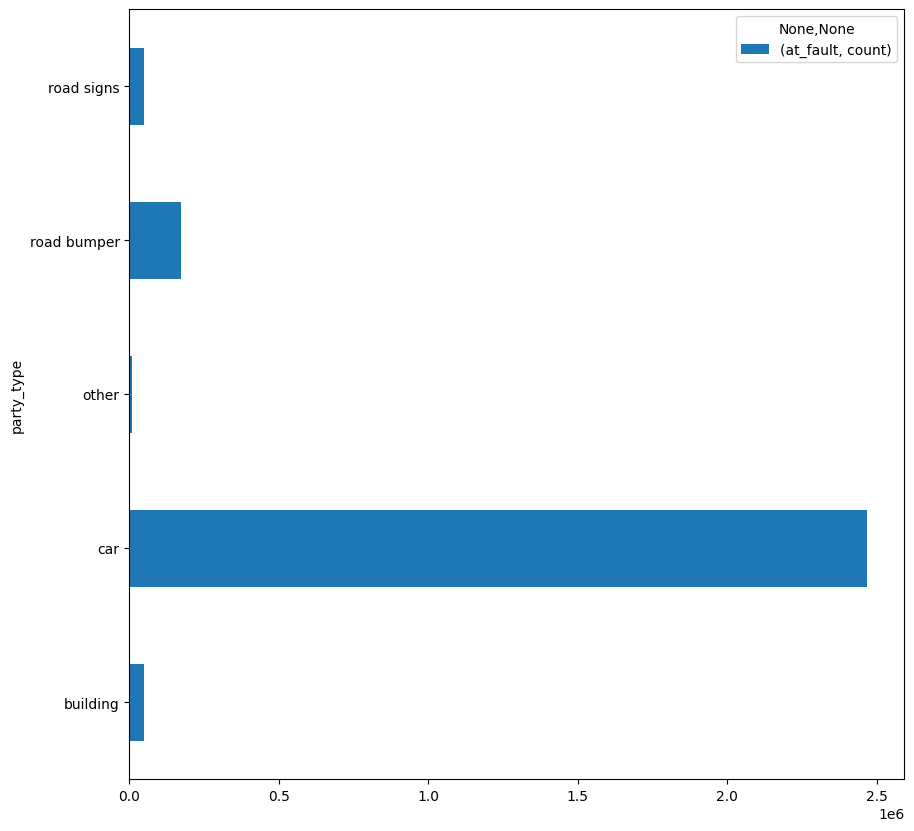

In [19]:
group_party_type.plot.barh(figsize=(10,10));
group_party_type

Наиболее частым участником проишествия является другой автомобиль, на втором месте дорожные знаки.

### Зависимость параметров автомобиля с суммой страховки

In [20]:
sql_parties = """
SELECT p.at_fault AS fault,
        p.insurance_premium AS insurance,
        v.vehicle_type AS v_type,
        v.vehicle_transmission AS v_transmission,
        v.vehicle_age AS age
FROM parties AS p
INNER JOIN vehicles AS v ON p.case_id = v.case_id
"""

df = pd.read_sql_query(sql_parties, con=engine)

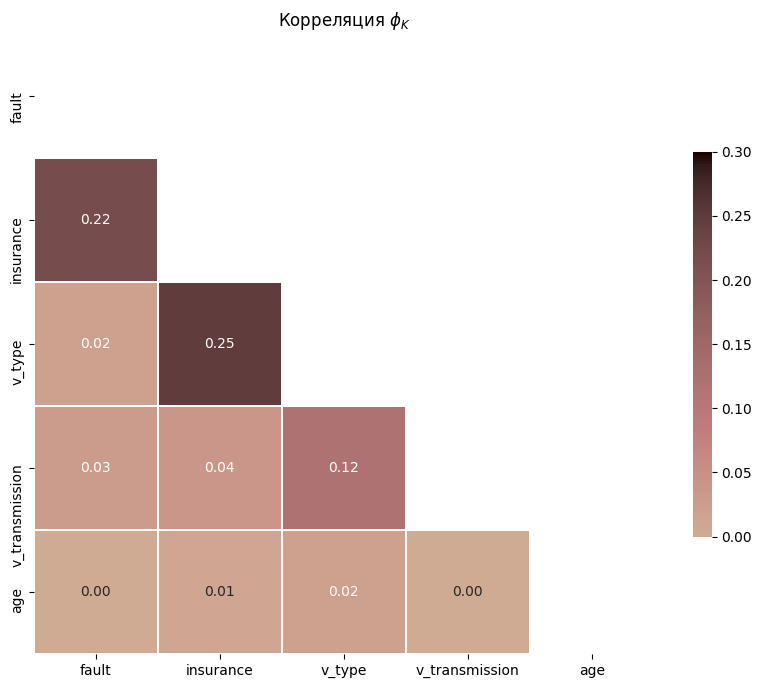

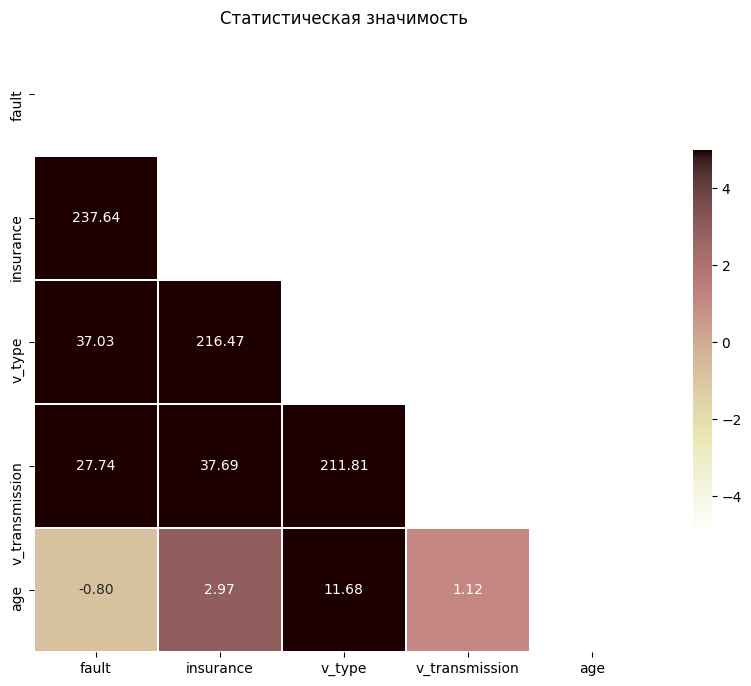

In [21]:
phik_sign(df)

Из анализа коррелляции и статистической значимости, можно сказать, что размер страховки не полностью, но в том числе зависит от типа кузова автомобиля, проверим есть ли зависимость между кузовом автомобиля, частотой его попадания в ДТП и размером страховки

In [22]:
sql_parties = """
WITH car AS (SELECT p.at_fault AS fault,
                    p.insurance_premium AS insurance,
                    v.vehicle_type AS v_type,
                    v.vehicle_transmission AS v_transmission,
                    v.vehicle_age AS age,
                    c.collision_date
            FROM parties AS p
            INNER JOIN vehicles AS v ON p.case_id = v.case_id
            INNER JOIN collisions AS c ON p.case_id = c.case_id)
SELECT fault,
        v_type,
        insurance,
        collision_date,
       COUNT(fault) OVER(PARTITION BY v_type) AS cnt_f,
       SUM(insurance) OVER(PARTITION BY v_type) AS sum_i
FROM car
"""

df = pd.read_sql_query(sql_parties, con=engine, parse_dates='collision_date')

In [23]:
df = df.drop_duplicates().reset_index(drop=True)
df = df.fillna(0)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451592 entries, 0 to 451591
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fault           451592 non-null  int64         
 1   v_type          451592 non-null  object        
 2   insurance       451592 non-null  float64       
 3   collision_date  451592 non-null  datetime64[ns]
 4   cnt_f           451592 non-null  int64         
 5   sum_i           451592 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 20.7+ MB


**Расспределение количества ДТП для каждого типа кузова**

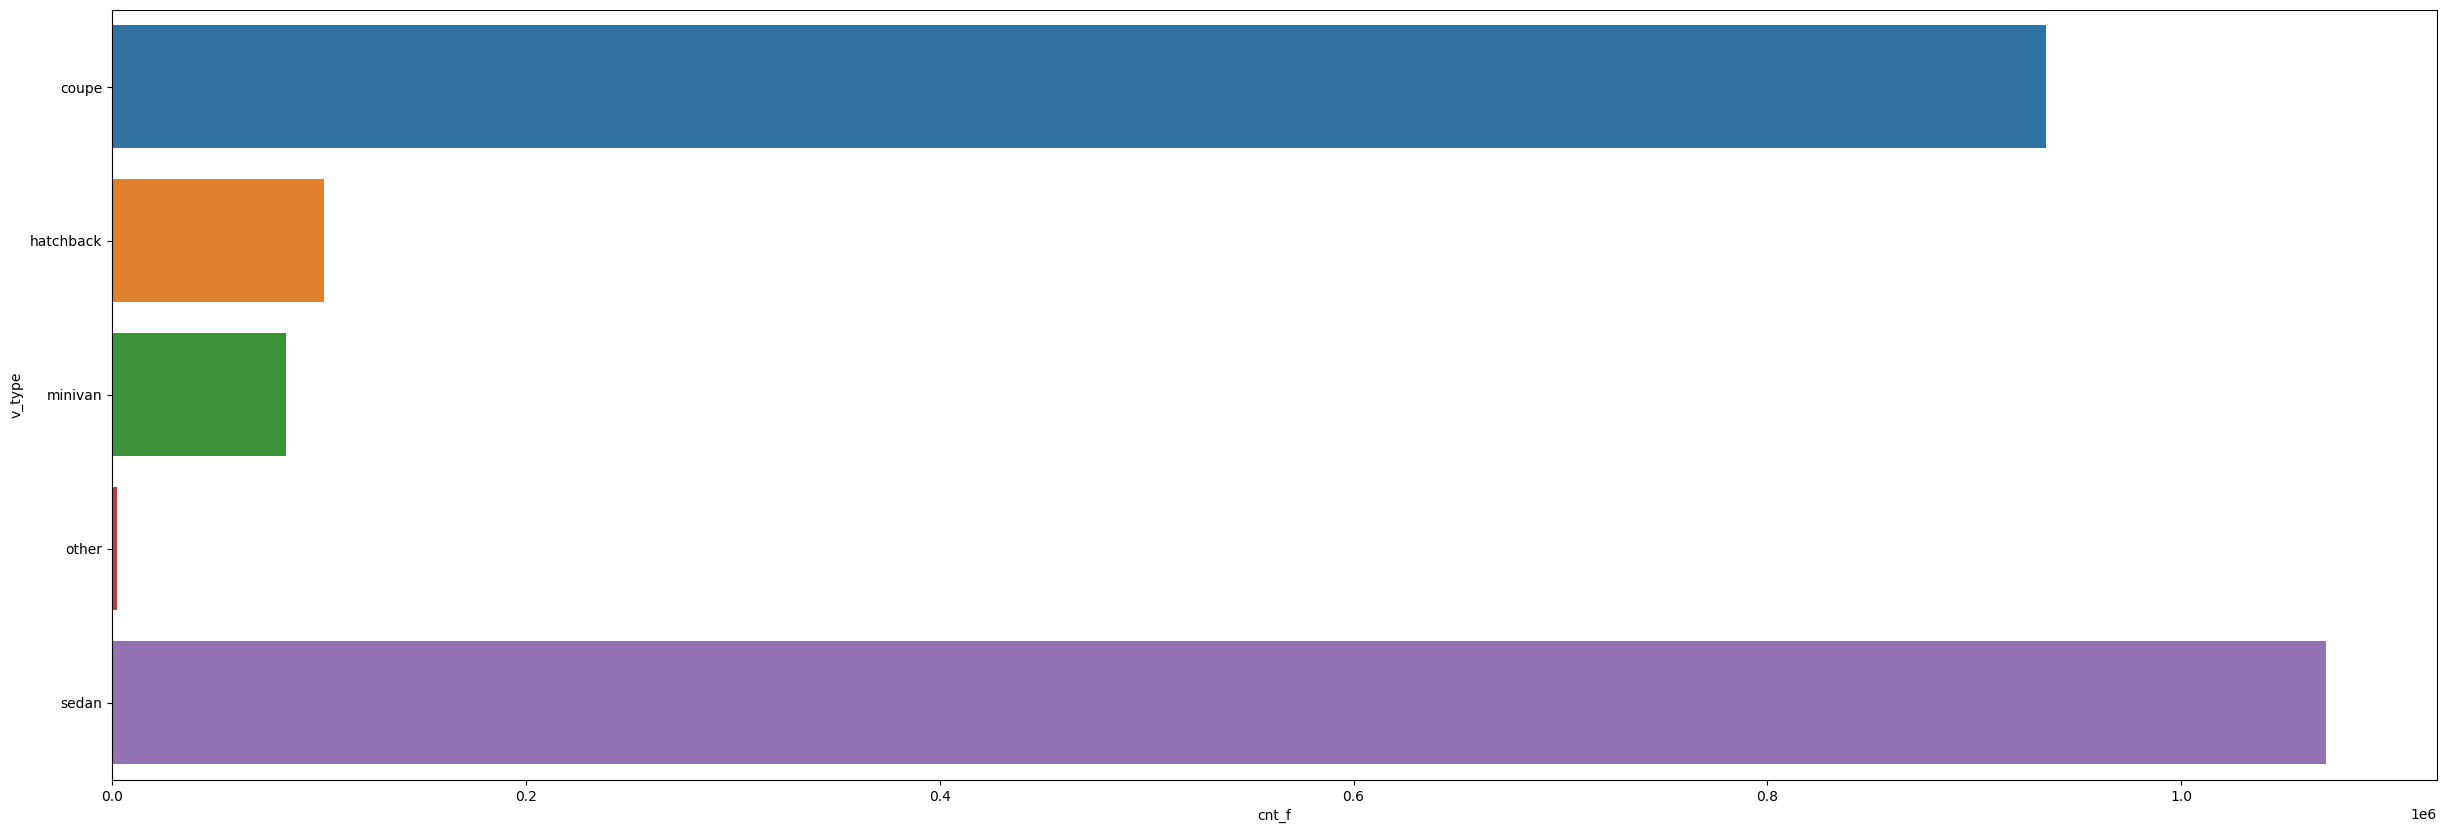

In [25]:
f, ax = plt.subplots(figsize=(30, 10))
sns.barplot(data=df, y='v_type', x='cnt_f', ax=ax);

**Расспределение суммы страховки и кузовом**

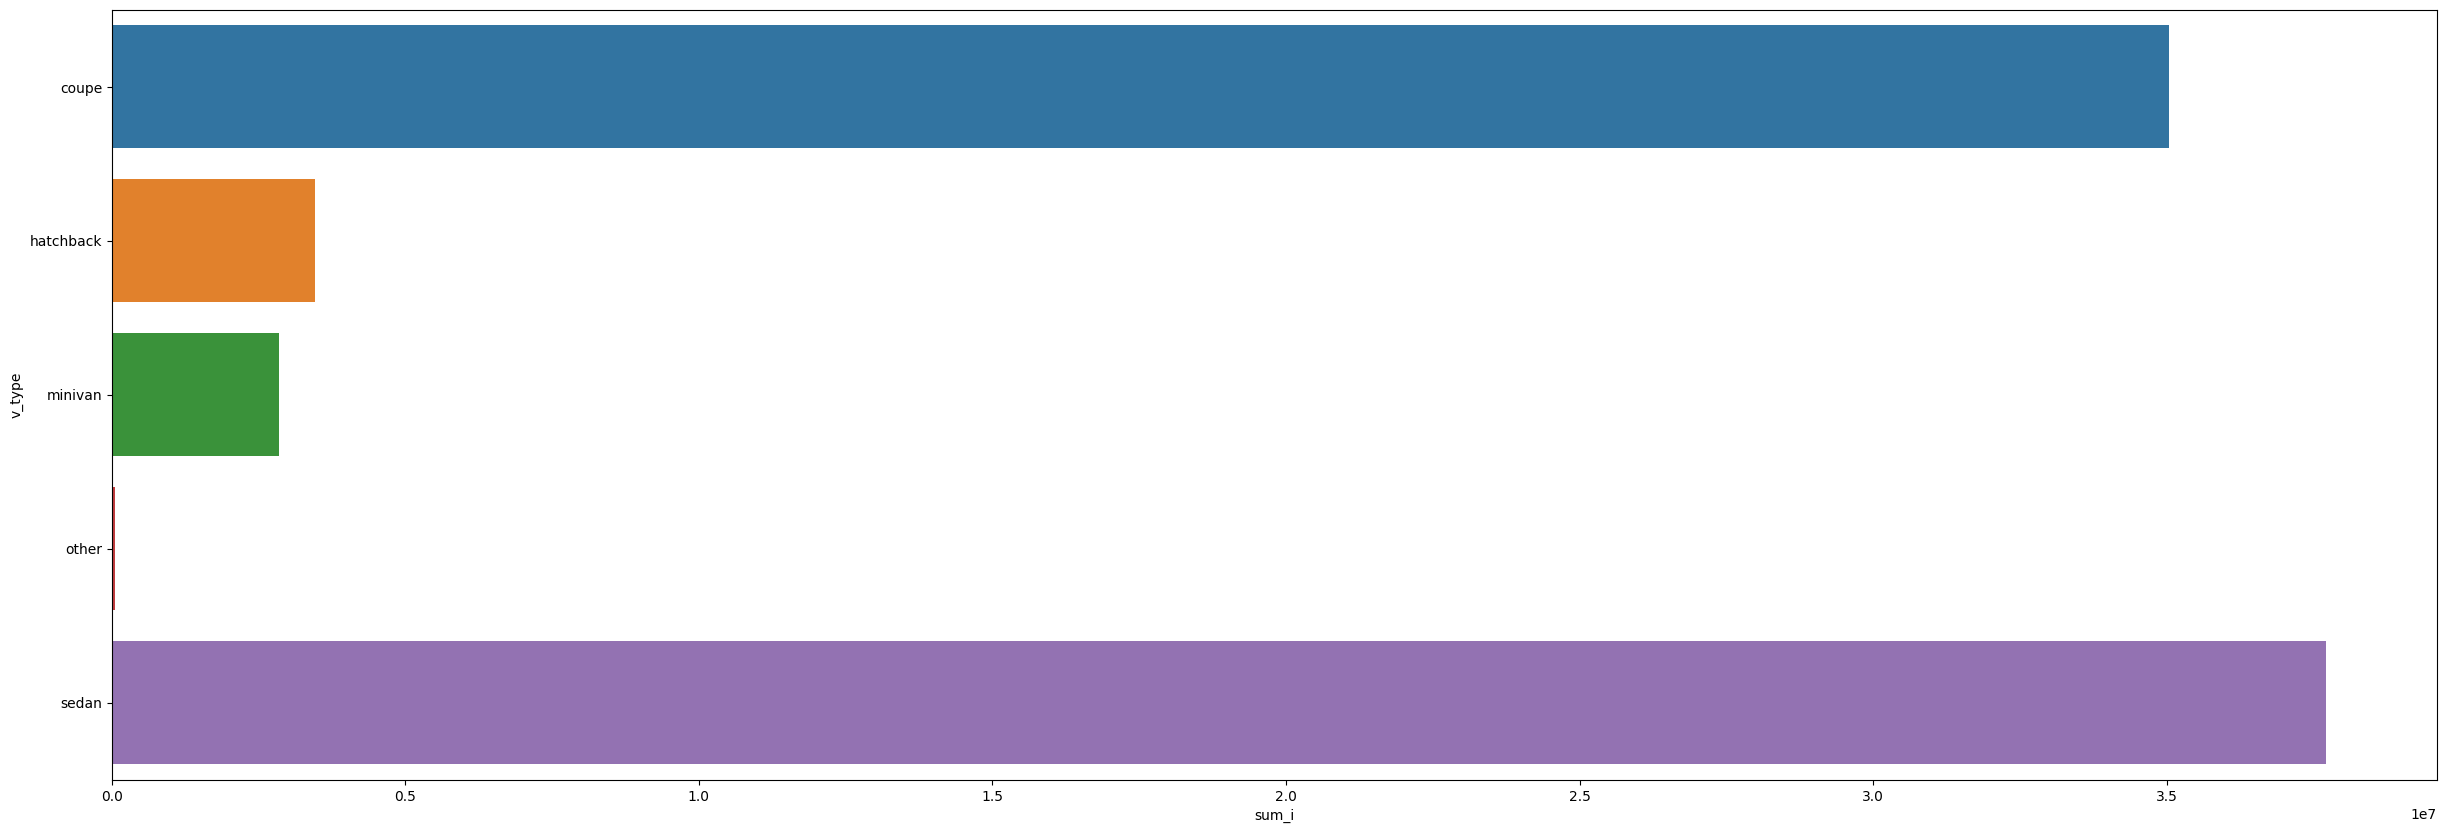

In [26]:
f, ax = plt.subplots(figsize=(30, 10))
sns.barplot(data=df, y='v_type', x='sum_i', ax=ax);

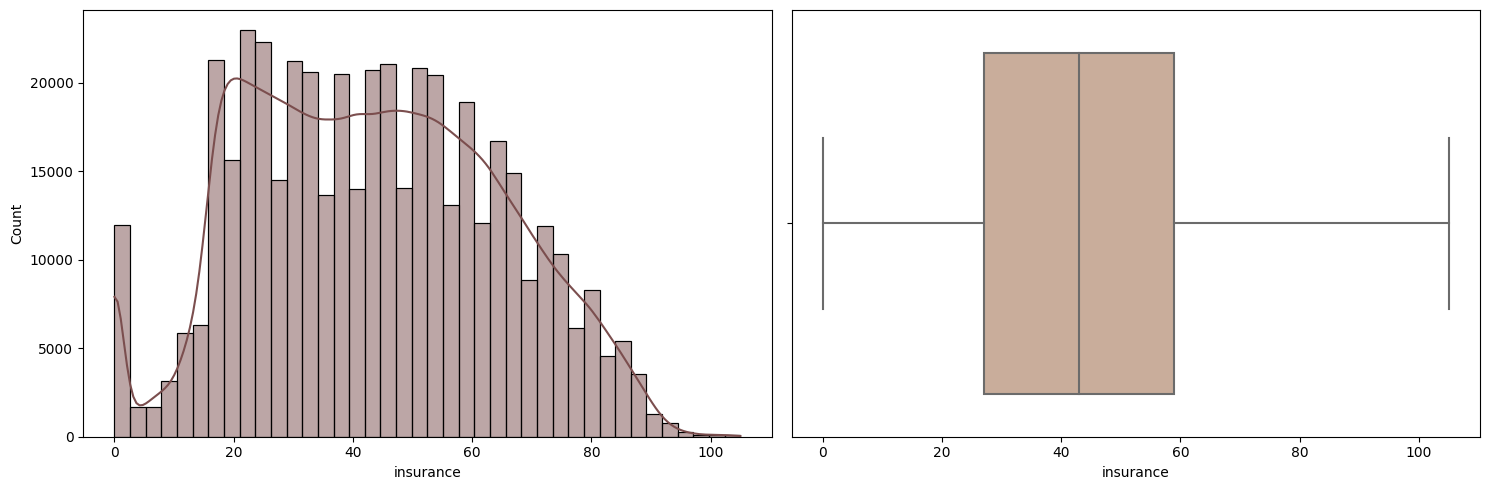

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['insurance'], ax=axes[0], kde=True, bins=40, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['insurance'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

По количеству аварий с лидирующие позиции занимают купе и седан они же имеют самые большие страховые взносы.

**Выводы**

- Наиболее опасными сезонами является весна и зима, это можно связать с сильным изменением погодных условий, таких как: температура, давление, количество осадков, скорость ветра. Можно предположить, что все эти параметры влияют на дорожное покрытие и видимость для автомобилиста, что повишает риск ДТП, что и видно на гистрограмме.

- Наиболее частым участником проишествия является другой автомобиль, на втором месте дорожные знаки.

- Из анализа коррелляции и статистической значимости, можно сказать, что размер страховки не полностью, но в том числе зависит от типа кузова автомобиля, анализ показал, что по количеству аварий лидирующие позиции занимают тип кузова купе и седан они же имеют самые большие страховые взносы.

# Оценка водительского риска и EDA

Подготовим данные согласно требованию заказчика.

- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.

Также добавим новый столбец указывающий на время года в которое было совершено ДТП и время суток основанное на значениях времени.

<AxesSubplot:>

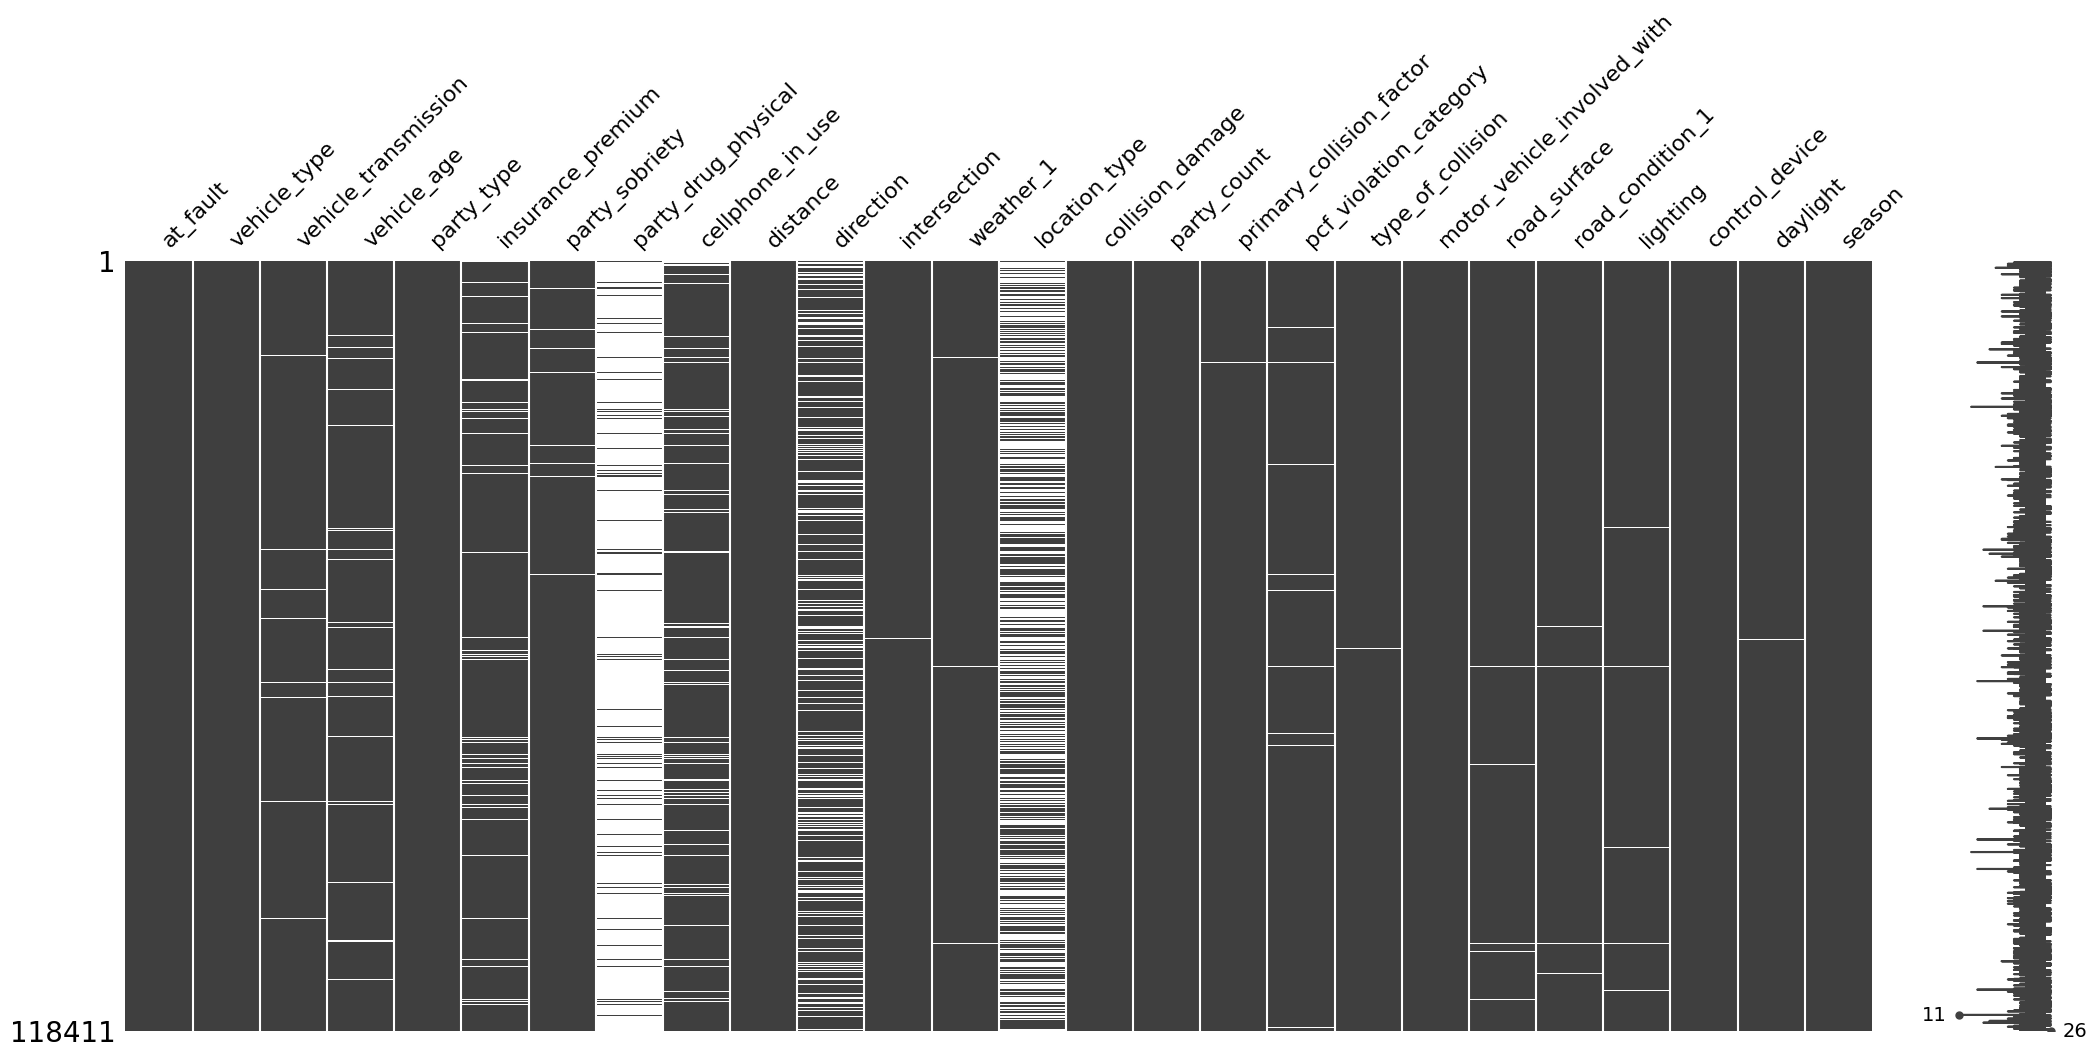

In [28]:
sql_query = '''
SELECT  at_fault,
		vehicle_type,
        vehicle_transmission,
        vehicle_age,
        party_type,
        insurance_premium,
        party_sobriety,
        party_drug_physical,
        cellphone_in_use,
        distance,
        direction,
        intersection,
        weather_1,
        location_type,
        collision_damage,
        party_count,
        primary_collision_factor,
        pcf_violation_category,
        type_of_collision,
        motor_vehicle_involved_with,
        road_surface,
        road_condition_1,
        lighting,
        control_device,
        daylight,
        season
FROM ((SELECT *,
            (CASE
                WHEN EXTRACT(MONTH FROM collision_date) = 12 OR EXTRACT(MONTH FROM collision_date) BETWEEN 1 AND 2 THEN 'winter'
                WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 3 AND 5 THEN 'spring'
                WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 6 AND 8 THEN 'summer'
                WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 9 AND 11 THEN 'autumn'
            END) AS season,
            (CASE
                WHEN EXTRACT(HOUR FROM collision_time) BETWEEN 0 AND 6 AND EXTRACT(MINUTE FROM collision_time) BETWEEN 0 AND 59 THEN 'night'
                WHEN EXTRACT(HOUR FROM collision_time) BETWEEN 7 AND 12 AND EXTRACT(MINUTE FROM collision_time) BETWEEN 0 AND 59 THEN 'morning'
                WHEN EXTRACT(HOUR FROM collision_time) BETWEEN 13 AND 18 AND EXTRACT(MINUTE FROM collision_time) BETWEEN 0 AND 59 THEN 'day'
                WHEN EXTRACT(HOUR FROM collision_time) BETWEEN 19 AND 23 AND EXTRACT(MINUTE FROM collision_time) BETWEEN 0 AND 59 THEN 'evening'
            END) AS daylight
	FROM collisions
	WHERE DATE_PART('year', collision_date) = 2012) AS c
	JOIN
	(SELECT *
	FROM parties
	WHERE party_type = 'car') AS p ON c.case_id = p.case_id
	JOIN
	(SELECT *
	FROM vehicles) AS v ON p.case_id = v.case_id)
WHERE collision_damage != 'scratch'
'''
#подключение к базе and p.party_number = v.party_number
df = pd.read_sql_query(sql_query, con=engine)
missingno.matrix(df)

In [29]:
info_df(df)

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   at_fault                     118411 non-null  int64  
 1   vehicle_type                 118411 non-null  object 
 2   vehicle_transmission         116545 non-null  object 
 3   vehicle_age                  115046 non-null  float64
 4   party_type                   118411 non-null  object 
 5   insurance_premium            113289 non-null  float64
 6   party_sobriety               116682 non-null  object 
 7   party_drug_physical          8695 non-null    object 
 8   cellphone_in_use             107507 non-null  float64
 9   distance                     118411 non-null  float64
 10  direction                    89466 non-null   object 
 11  intersection            

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,distance,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,daylight,season
0,1,sedan,manual,0.0,car,19.0,had not been drinking,None,0.0,36.0,...,vehicle code violation,speeding,rear end,other motor vehicle,wet,normal,daylight,functioning,morning,winter
1,0,sedan,manual,0.0,car,26.0,had not been drinking,None,0.0,36.0,...,vehicle code violation,speeding,rear end,other motor vehicle,wet,normal,daylight,functioning,morning,winter
2,1,hatchback,auto,1.0,car,47.0,had not been drinking,None,0.0,162.0,...,vehicle code violation,None,other,other object,dry,normal,daylight,none,day,winter
3,1,sedan,auto,2.0,car,20.0,had not been drinking,None,0.0,150.0,...,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,dusk or dawn,functioning,day,winter
4,0,hatchback,manual,11.0,car,33.0,had not been drinking,None,0.0,0.0,...,vehicle code violation,pedestrian violation,other,other object,dry,normal,dark with street lights,functioning,day,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,1,coupe,auto,9.0,car,62.0,had not been drinking,None,0.0,0.0,...,vehicle code violation,improper turning,head-on,other motor vehicle,dry,normal,dark with street lights,functioning,day,winter
118407,1,sedan,auto,9.0,car,62.0,had not been drinking,None,0.0,0.0,...,vehicle code violation,improper turning,head-on,other motor vehicle,dry,normal,dark with street lights,functioning,day,winter
118408,0,coupe,auto,9.0,car,62.0,had not been drinking,None,0.0,0.0,...,vehicle code violation,improper turning,head-on,other motor vehicle,dry,normal,dark with street lights,functioning,day,winter
118409,0,sedan,auto,9.0,car,62.0,had not been drinking,None,0.0,0.0,...,vehicle code violation,improper turning,head-on,other motor vehicle,dry,normal,dark with street lights,functioning,day,winter


--------------------
| Сумма дубликатов |
--------------------
2556
--------------------------------------
| Уникальные значения признака vehicle_type |
--------------------------------------
['sedan' 'hatchback' 'coupe' 'minivan' 'other']
--------------------------------------
| Уникальные значения признака vehicle_transmission |
--------------------------------------
['manual' 'auto' None]
--------------------------------------
| Уникальные значения признака party_type |
--------------------------------------
['car']
--------------------------------------
| Уникальные значения признака party_sobriety |
--------------------------------------
['had not been drinking' 'impairment unknown'
 'had been drinking, not under influence' None
 'had been drinking, under influence'
 'had been drinking, impairment unknown' 'not applicable']
--------------------------------------
| Уникальные значения признака party_drug_physical |
--------------------------------------
[None 'G' 'impairment - phys

In [30]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
(pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
at_fault,0.000000
vehicle_type,0.000000
vehicle_transmission,1.600000
vehicle_age,2.800000
party_type,0.000000
insurance_premium,4.300000
party_sobriety,1.500000
party_drug_physical,92.700000
cellphone_in_use,9.200000
distance,0.000000


Из первичного анализа видно, что в данных существую пропуски и не явные дубликаты. Выполним исследовательский анализ данных для выбора признаков.

### vehicle_transmission

Можно предлополижить что разница в типе трансмиссии будет влиять на вероятность ДТП из-за неисправности.

Нулевая гипотеза звучит как: количество ДТП с механической КПП не отличается от автомобиля с автоматической КПП.

Альтернативная гипотеза: наличие механической коробки передач увеличивает количество ДТП.

Пропуски в данных заполнить не представляется возможным, так как тип кузова не может дать никакой информации о типе КПП, а другой технической информации о машине у нас нет. Процент пропуска от всего набора данных составляет 1.6% что не является серьезным значением, удалим пропуски.

In [31]:
df = df.loc[df['vehicle_transmission'].isna() == False]

In [32]:
# ДТП при РКПП
fault_manula = df.loc[df['vehicle_transmission'] == 'manual', 'at_fault']
# ДТП при АКПП
fault_auto = df.loc[df['vehicle_transmission'] == 'auto', 'at_fault']
# Уровень статистической значимости
alpha = .05

results = st.ttest_ind(fault_manula, fault_auto, alternative='greater')
print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 4.2056519367994095e-19
Отвергаем нулевую гипотезу


Статестический тест показал, что тип коробки передач действительно влияет на количество аварий, скорее всего это свзязано с надежностью РКПП, оставим эти данные и преобразуем тип данных

In [33]:
df['vehicle_transmission'] = df['vehicle_transmission'].astype('category')

**Выбросы в данных**

Проверим данные на аномальные значения

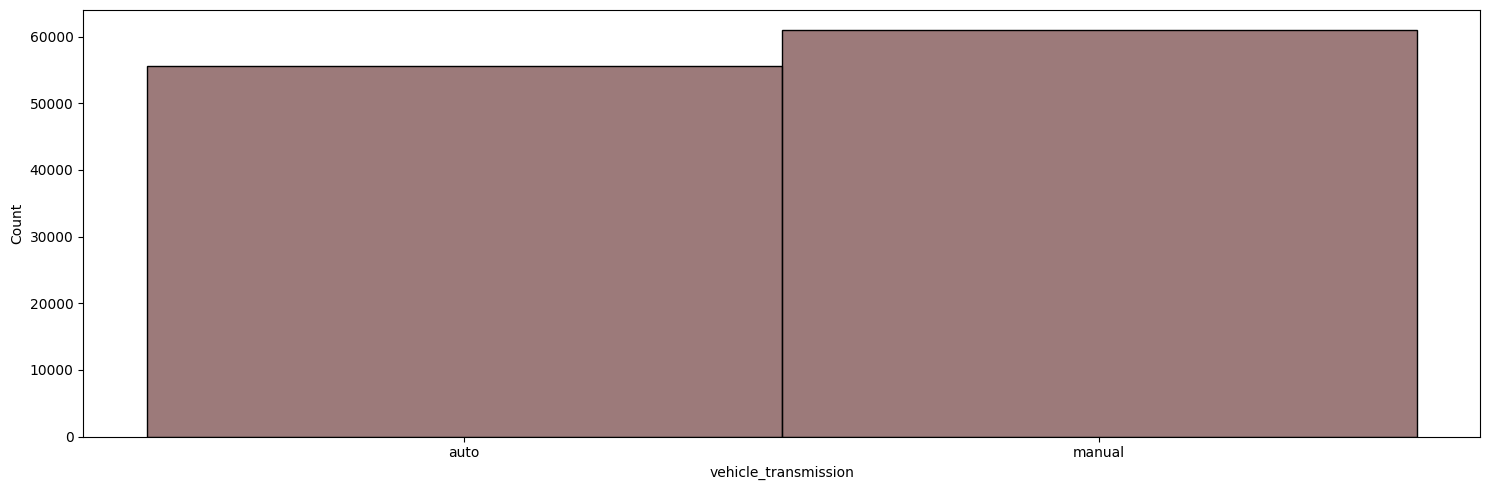

In [34]:
fig, axes = plt.subplots( figsize=(15, 5))
sns.histplot(df['vehicle_transmission'], bins=40, edgecolor='black', color=sns.color_palette("pink")[0])

plt.tight_layout()
plt.show()

Сильного дисбаланса нет

### vehicle_age

Основываясь на информации о известных суммах страховки для того или иного кузова авто, попробуем восстановить данные для пропущенных значений.

In [35]:
df.loc[df['vehicle_age'].isna() == True]

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,distance,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,daylight,season
33,0,sedan,auto,NaN,car,31.0,had not been drinking,None,0.0,500.0,...,vehicle code violation,improper turning,sideswipe,other motor vehicle,dry,normal,dark with street lights,none,evening,spring
43,1,sedan,auto,NaN,car,46.0,had not been drinking,None,0.0,528.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,morning,spring
158,1,sedan,manual,NaN,car,30.0,had not been drinking,None,0.0,218.0,...,vehicle code violation,speeding,rear end,other motor vehicle,wet,normal,daylight,functioning,morning,winter
159,0,sedan,manual,NaN,car,51.0,had not been drinking,None,0.0,218.0,...,vehicle code violation,speeding,rear end,other motor vehicle,wet,normal,daylight,functioning,morning,winter
160,0,sedan,manual,NaN,car,NaN,had not been drinking,None,0.0,218.0,...,vehicle code violation,speeding,rear end,other motor vehicle,wet,normal,daylight,functioning,morning,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118056,1,sedan,auto,NaN,car,24.0,had not been drinking,None,1.0,0.0,...,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,None,spring
118061,0,sedan,auto,NaN,car,34.0,had not been drinking,None,0.0,0.0,...,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,None,spring
118063,0,sedan,auto,NaN,car,38.0,had not been drinking,None,0.0,0.0,...,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,None,spring
118315,1,sedan,manual,NaN,car,55.0,had not been drinking,None,0.0,2640.0,...,vehicle code violation,unsafe starting or backing,rear end,other motor vehicle,dry,normal,daylight,none,day,summer


In [36]:
(df.loc[df['vehicle_age'].isna() == False,
        ['insurance_premium', 'vehicle_type', 'vehicle_age']]
        .groupby('vehicle_type')[['insurance_premium', 'vehicle_age']]
        .agg({'median'}))

,insurance_premium,vehicle_age
,median,median
vehicle_type,,
coupe,37.0,5.0
hatchback,41.0,5.0
minivan,42.0,4.0
other,26.0,4.0
sedan,35.0,4.0


In [37]:
for v_type in df['vehicle_type'].unique():
    df.loc[(df['vehicle_type'] == v_type)
            & (df['vehicle_age'].isna() == True),'vehicle_age'] = \
    df.loc[(df['vehicle_type'] == v_type)
                   & (df['vehicle_age'].isna() == False),
                     'vehicle_age'].median()

**Выбросы в данных**

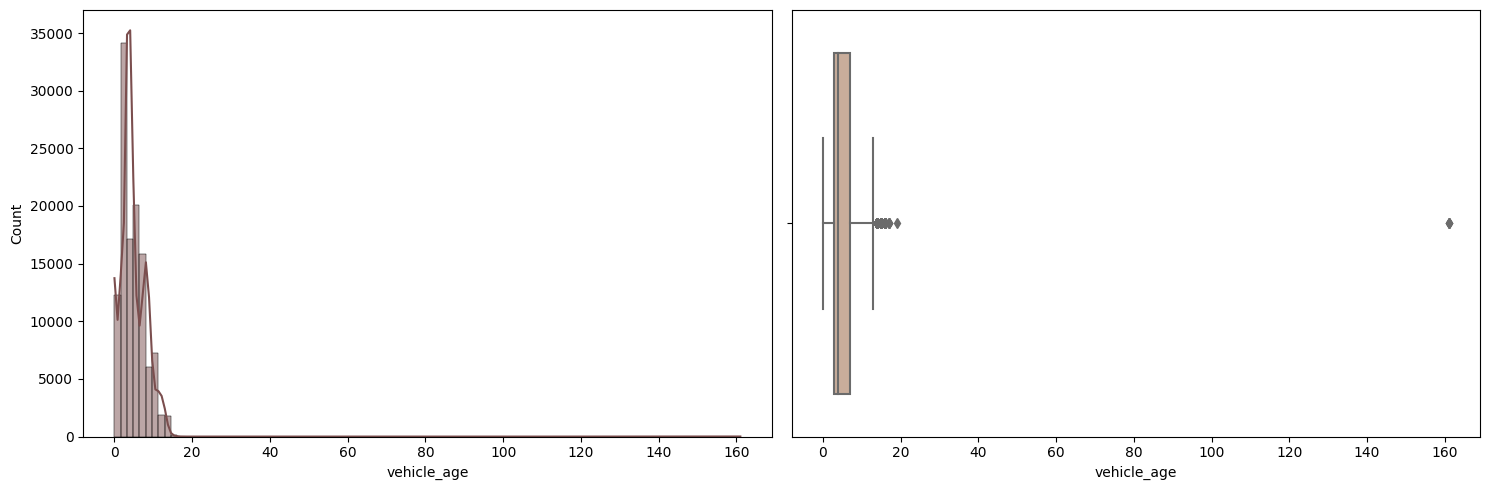

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['vehicle_age'], ax=axes[0], kde=True, bins=100, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['vehicle_age'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

В признаке возраст авто присутсвуют аномальные значения в возрасте авто в 160 лет. Удалим эти данные

In [39]:
df = df.loc[df['vehicle_age'] <= 20]

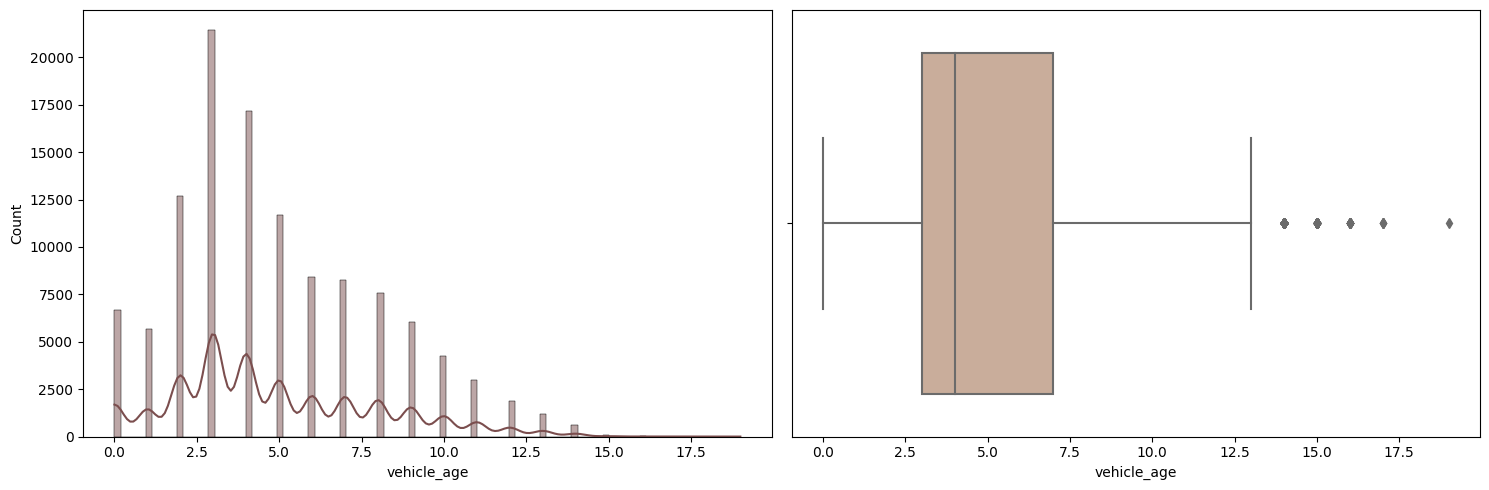

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['vehicle_age'], ax=axes[0], kde=True, bins=100, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['vehicle_age'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

In [41]:
df['vehicle_age'] = df['vehicle_age'].astype('int8')

### insurance_premium

Проанализируем, какой из параметров больше влияет на стоимость страховки, тип кузова или возраст автомобиля.

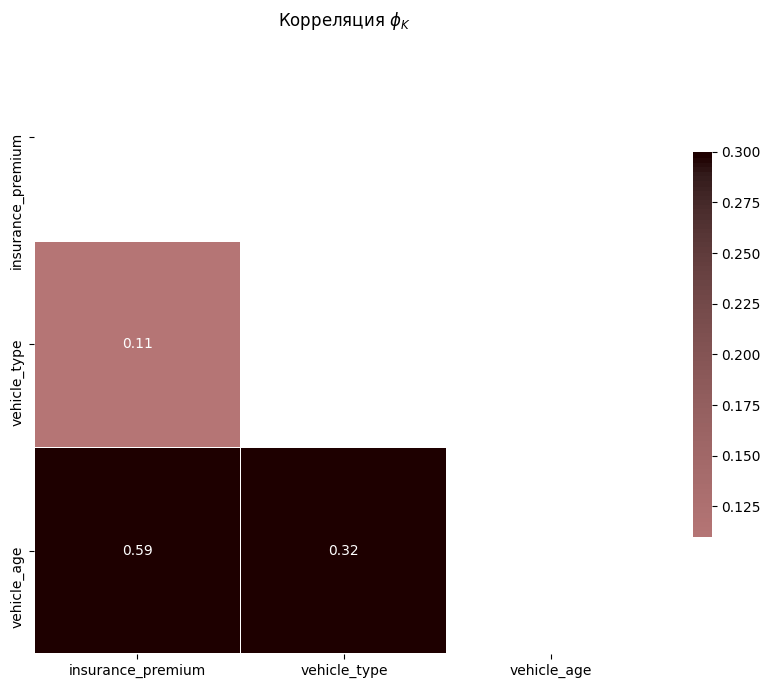

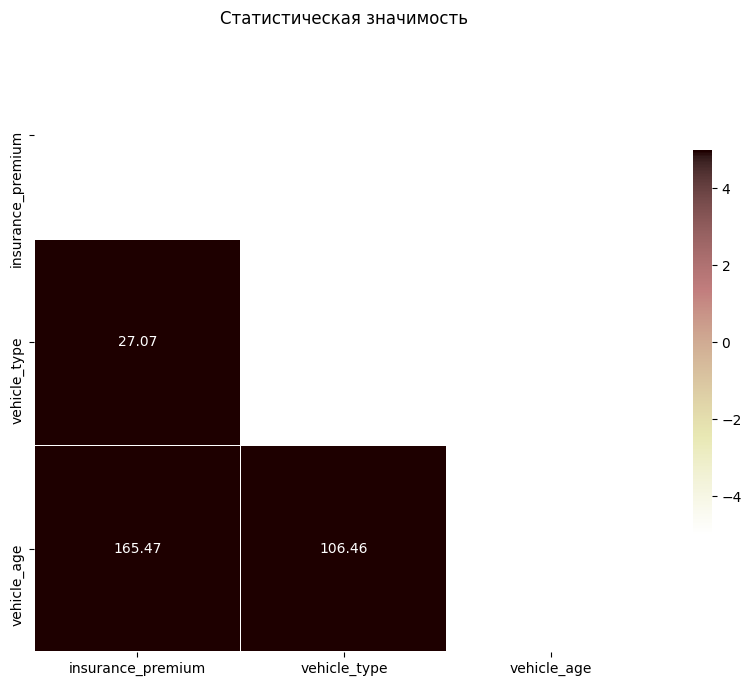

In [42]:
phik_sign(df.loc[df['insurance_premium'].isna() == False, ['insurance_premium', 'vehicle_type','vehicle_age']])

Из анализа корреляции и уровня статистической значимости, можно сказать, что тип возраст авто больше коррелирует с стоимостью страховки чем тип кузова.

In [43]:
df.loc[df['insurance_premium'].isna() == True]

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,distance,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,daylight,season
8,1,sedan,auto,3,car,NaN,impairment unknown,G,NaN,0.0,...,vehicle code violation,improper turning,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,day,winter
15,1,sedan,auto,3,car,NaN,impairment unknown,G,0.0,1.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,dark with no street lights,none,night,winter
27,1,sedan,auto,3,car,NaN,impairment unknown,G,0.0,1584.0,...,vehicle code violation,improper turning,sideswipe,other motor vehicle,dry,normal,daylight,none,morning,winter
34,1,sedan,manual,3,car,NaN,had not been drinking,None,1.0,147.0,...,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,night,spring
58,1,coupe,manual,5,car,NaN,impairment unknown,G,0.0,0.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,day,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118259,1,minivan,manual,5,car,NaN,impairment unknown,G,0.0,50.0,...,vehicle code violation,traffic signals and signs,other,bicycle,dry,normal,dark with street lights not functioning,functioning,evening,spring
118269,0,minivan,manual,6,car,NaN,impairment unknown,G,0.0,0.0,...,vehicle code violation,traffic signals and signs,broadside,bicycle,dry,normal,dark with street lights,functioning,day,winter
118319,1,coupe,manual,6,car,NaN,impairment unknown,G,0.0,100.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,day,spring
118370,1,sedan,manual,6,car,NaN,impairment unknown,G,0.0,600.0,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with no street lights,none,day,winter


In [44]:
for v_type in df['vehicle_age'].unique():
    df.loc[(df['vehicle_age'] == v_type)
            & (df['insurance_premium'].isna() == True),'insurance_premium'] = \
    df.loc[(df['vehicle_age'] == v_type)
                   & (df['insurance_premium'].isna() == False),
                     'insurance_premium'].median()

**Выбросы в данных**

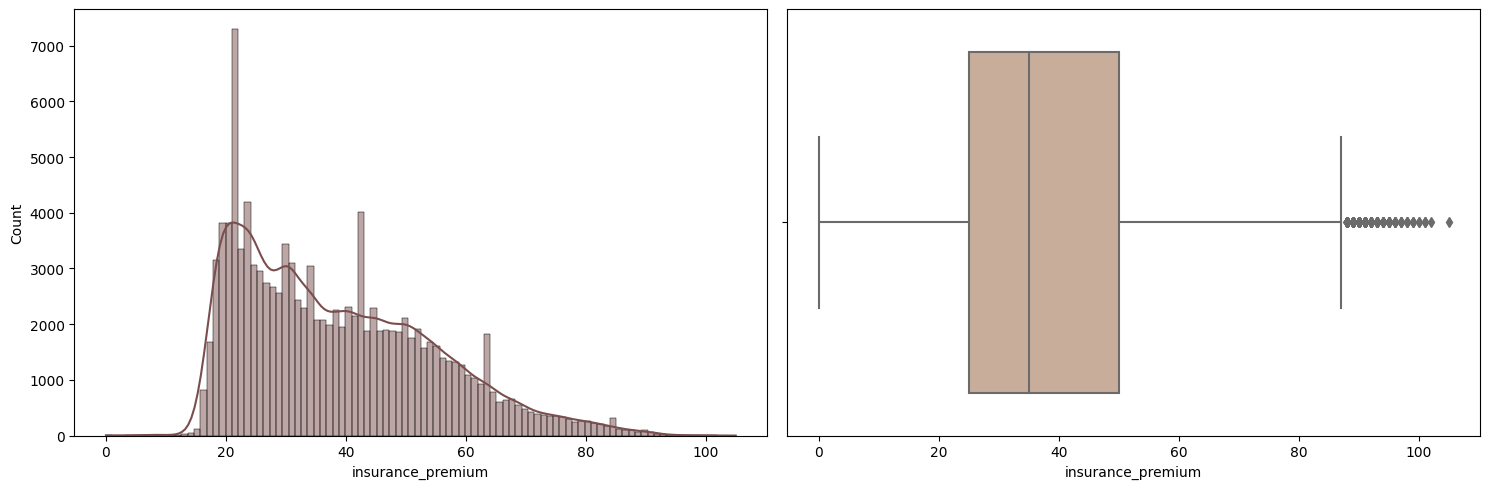

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['insurance_premium'], ax=axes[0], kde=True, bins=100, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['insurance_premium'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

In [46]:
df['insurance_premium'] = df['insurance_premium'].astype('int8')

Выбросы в данных присутствуют, но их количество сильно меньше, чем значений входяших в распределение, оставим эти данные.

### party_sobriety

Данные о трезвости водителя, может являтся одним из ключевых параметров при обучении, но пропуски объемом в 1.6% можно удалить.

In [47]:
df.loc[df['party_sobriety'].isna() == True]

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,distance,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,daylight,season
21,0,sedan,auto,3,car,37,None,None,NaN,1000.0,...,vehicle code violation,unsafe lane change,hit object,fixed object,dry,normal,daylight,none,morning,winter
77,1,hatchback,manual,0,car,24,None,None,0.0,4.0,...,vehicle code violation,speeding,other,other object,wet,normal,daylight,none,day,spring
88,1,sedan,manual,2,car,22,None,None,0.0,113.0,...,vehicle code violation,speeding,sideswipe,other motor vehicle,dry,normal,daylight,none,morning,spring
341,1,coupe,manual,6,car,38,None,under drug influence,0.0,530.0,...,vehicle code violation,dui,hit object,fixed object,dry,normal,daylight,none,morning,winter
364,1,coupe,manual,3,car,20,None,under drug influence,0.0,325.0,...,vehicle code violation,dui,hit object,fixed object,dry,normal,daylight,none,night,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117783,0,coupe,auto,8,car,73,None,None,0.0,0.0,...,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,none,morning,spring
117855,1,sedan,manual,6,car,31,None,sleepy/fatigued,0.0,790.0,...,vehicle code violation,wrong side of road,sideswipe,other motor vehicle,dry,normal,daylight,none,night,spring
118187,0,sedan,auto,2,car,28,None,None,0.0,408.0,...,vehicle code violation,automobile right of way,head-on,other motor vehicle,dry,normal,dark with street lights,functioning,evening,spring
118188,0,coupe,auto,4,car,28,None,None,0.0,408.0,...,vehicle code violation,automobile right of way,head-on,other motor vehicle,dry,normal,dark with street lights,functioning,evening,spring


In [48]:
df = df.loc[df['party_sobriety'].isna() == False]

In [49]:
df['party_sobriety'] = df['party_sobriety'].astype('category')

### party_drug_physical

Состояние участника: физическое или с учётом принятых лекарств так же как и предыдущий потенциально может быть важен для анализа, но объем пропущенных значений черезмерно велик, а существущие записи не репрезентативны для восстановления пропусков, предлагается пробелы заполнить значениями `G` = Impairment Unknown

In [50]:
df.loc[df['party_drug_physical'].isna() == False]

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,distance,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,daylight,season
8,1,sedan,auto,3,car,24,impairment unknown,G,NaN,0.0,...,vehicle code violation,improper turning,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,day,winter
15,1,sedan,auto,3,car,24,impairment unknown,G,0.0,1.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,dark with no street lights,none,night,winter
27,1,sedan,auto,3,car,24,impairment unknown,G,0.0,1584.0,...,vehicle code violation,improper turning,sideswipe,other motor vehicle,dry,normal,daylight,none,morning,winter
48,1,coupe,manual,5,car,36,impairment unknown,G,NaN,2640.0,...,vehicle code violation,improper turning,overturned,non-collision,dry,normal,daylight,none,day,summer
58,1,coupe,manual,5,car,34,impairment unknown,G,0.0,0.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,day,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118287,1,sedan,auto,1,car,27,impairment unknown,G,0.0,40.0,...,vehicle code violation,unsafe starting or backing,other,parked motor vehicle,dry,normal,daylight,none,day,spring
118319,1,coupe,manual,6,car,40,impairment unknown,G,0.0,100.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,day,spring
118370,1,sedan,manual,6,car,40,impairment unknown,G,0.0,600.0,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with no street lights,none,day,winter
118395,1,sedan,manual,2,car,29,impairment unknown,G,0.0,500.0,...,vehicle code violation,speeding,sideswipe,other motor vehicle,dry,normal,daylight,none,day,winter


In [51]:
df.loc[df['party_drug_physical'].isna() == True, 'party_drug_physical'] = 'G'

In [52]:
df['party_drug_physical'] = df['party_drug_physical'].astype('category')

### cellphone_in_use

Информация о том пользовался ли водитель телефоном или нет, также потенциально очень важна для построения модели, пропуски в данных заполним 0

In [53]:
df.loc[df['cellphone_in_use'].isna() == True, 'cellphone_in_use'] = 0
df['cellphone_in_use'] = df['cellphone_in_use'].astype('int8')

### direction

Восстановить значения направлений движений также не представляется возможным, предлагается перекодировать значения направлений с 1 до 4, а для пустых значений присвоим 0

In [54]:
direction = {'north' : 1, 'east' : 2, 'west': 3, 'south': 4}

df['direction'].replace(direction, inplace=True)

In [55]:
df.loc[df['direction'].isna() == True, 'direction'] = 0
df['direction'] = df['direction'].astype('int8')

### intersection и weather_1

Объем пропусков для каждого признака на уровне 0.3% от общего объема, таким пропуском можно принебречь

In [56]:
df = df.loc[df['intersection'].isna() == False]
df = df.loc[df['weather_1'].isna() == False]

In [57]:
df['intersection'] = df['intersection'].astype('int8')
df['weather_1'] = df['weather_1'].astype('category')

### location_type

Пропуски в типе дороге заполним `other`

In [58]:
df['location_type'] = df['location_type'].fillna('other')
df['location_type'] = df['location_type'].astype('category')


### Пропуски данных менее 1.5%

Для признаков у которых имеются пропуски в данных на уровне менее 1.5% предлагается удалить пропуски.

In [59]:
df = df.loc[df['primary_collision_factor'].isna() == False]
df = df.loc[df['pcf_violation_category'].isna() == False]
df = df.loc[df['type_of_collision'].isna() == False]
df = df.loc[df['motor_vehicle_involved_with'].isna() == False]
df = df.loc[df['road_surface'].isna() == False]
df = df.loc[df['road_condition_1'].isna() == False]
df = df.loc[df['lighting'].isna() == False]
df = df.loc[df['control_device'].isna() == False]
df = df.loc[df['daylight'].isna() == False]

## Преобразование типов данных и удаление дубликатов

Оптимизируем типы данных для признаков

In [60]:
df[['at_fault', 'party_count']] = df[['at_fault', 'party_count']].astype('int8')
df[['vehicle_type', 'party_type','collision_damage','primary_collision_factor',
    'pcf_violation_category','type_of_collision','motor_vehicle_involved_with',
    'road_surface','road_condition_1','lighting','control_device','daylight',
    'season']] = \
    df[['vehicle_type', 'party_type','collision_damage','primary_collision_factor',
    'pcf_violation_category','type_of_collision','motor_vehicle_involved_with',
    'road_surface','road_condition_1','lighting','control_device','daylight',
    'season']].astype('category')

In [61]:
df['distance'] = df['distance'].astype('int16')

Еще раз взглянем на статистику по нашим данным

In [62]:
df.describe()

,at_fault,vehicle_age,insurance_premium,cellphone_in_use,distance,direction,intersection,party_count
count,110472.000000,110472.000000,110472.000000,110472.00000,110472.000000,110472.000000,110472.000000,110472.000000
mean,0.468671,4.874719,38.494632,0.01939,677.314161,1.905243,0.228664,2.358308
std,0.499020,3.096134,16.133074,0.13789,1936.197156,1.471893,0.419974,0.948894
min,0.000000,0.000000,0.000000,0.00000,-31744.000000,0.000000,0.000000,1.000000
25%,0.000000,3.000000,25.000000,0.00000,5.000000,1.000000,0.000000,2.000000
50%,0.000000,4.000000,35.000000,0.00000,125.000000,2.000000,0.000000,2.000000
75%,1.000000,7.000000,50.000000,0.00000,528.000000,3.000000,0.000000,3.000000
max,1.000000,19.000000,105.000000,1.00000,32736.000000,4.000000,1.000000,10.000000


Видно что было упущено аномальное значение для параметра `distance`. Однозначно определить предельно возможное расстояние до главное дороги затруднительно, исходя из анализа статей ([ГОСТ Р 58653-2019](https://files.stroyinf.ru/Data2/1/4293725/4293725783.htm?ysclid=lrupvso19e520973235#i52115) и [Interstate Highway standards](https://translated.turbopages.org/proxy_u/en-ru.ru.3f185375-65b3bd3d-2e88835d-74722d776562/https/en.wikipedia.org/wiki/Interstate_Highway_standards)), можно сделать предположение, что ограничение в два стандартных отклонения может быть решением.

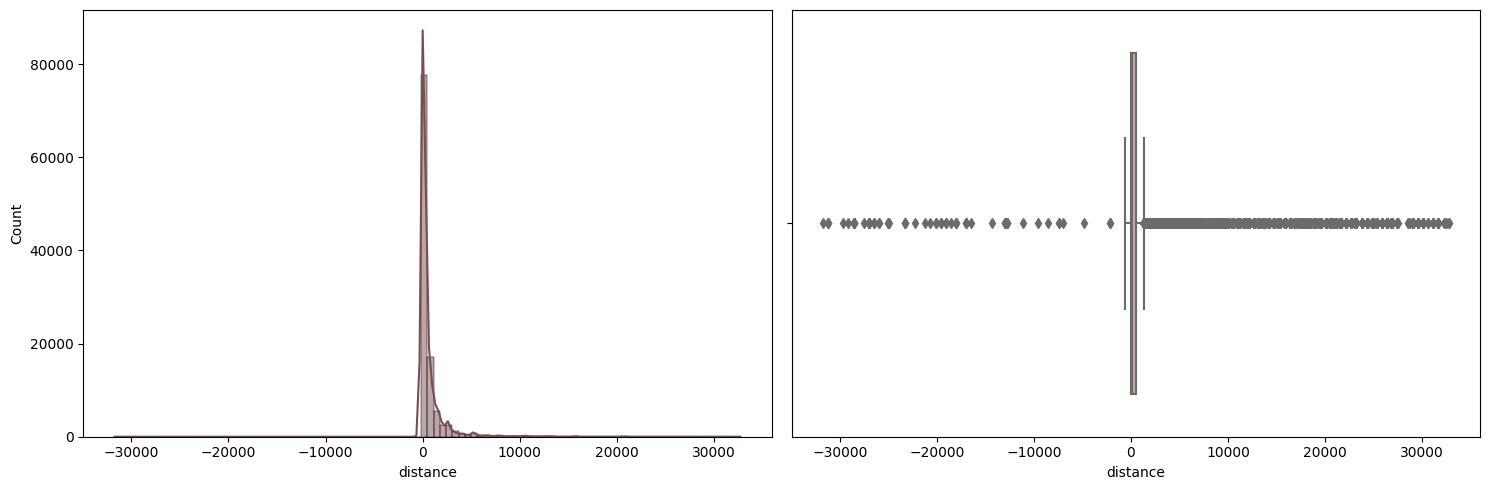

In [63]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['distance'], ax=axes[0], kde=True, bins=100, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['distance'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

In [64]:
df['distance'] = df['distance'].abs()
df = df.loc[df['distance'] < df['distance'].std()]

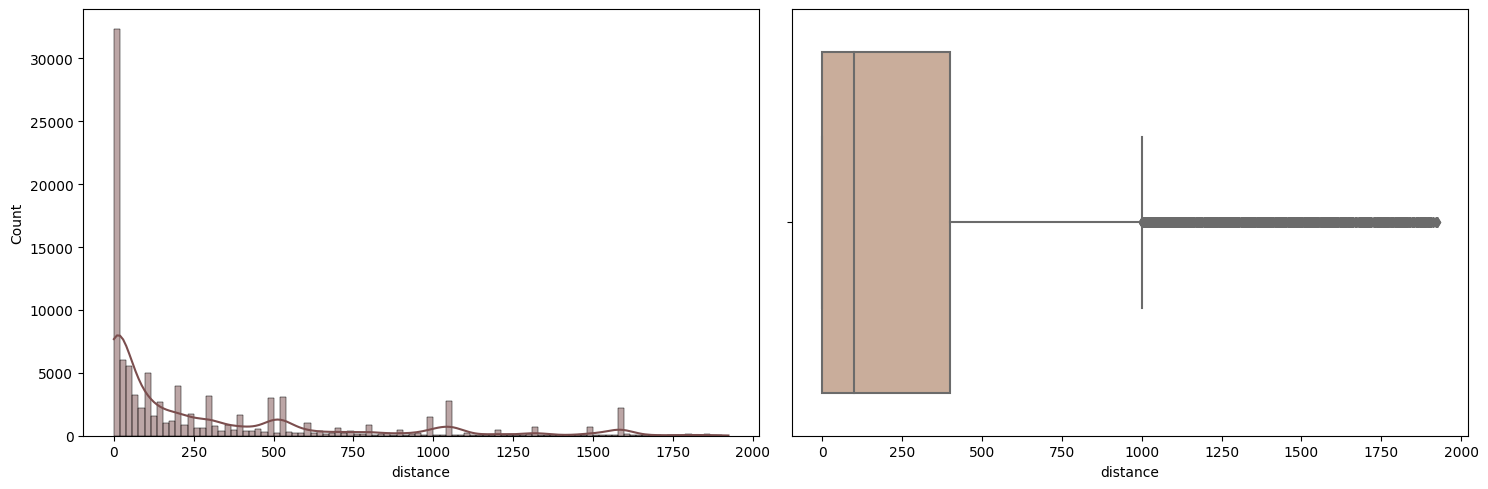

In [65]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['distance'], ax=axes[0], kde=True, bins=100, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['distance'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

In [66]:
df = df.drop_duplicates().reset_index(drop=True)

**Выводы**

Подготовлены данные согласно требованию заказчика.

- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.

Также добавлен новый столбец указывающий на время года в которое было совершено ДТП и время суток основанное на значениях времени.

Для большинства данных с пропусками, было выполнено заполнение этих пропусков в зависимости от специфики признака, для данных объем пропуском которых составлял менее 1.5% было принято решение об удалении пустых строк.

# Подготовка признаков и построение базовых моделей

Разобьем данные по соотношению 3:1:1, создав только три выборки, обучающую, валидационную и тестовую.

In [239]:
target = df['at_fault']
features = df.drop('at_fault', axis=1)

In [241]:
features_, features_test, target_, target_test \
= train_test_split(features, target, test_size = 0.2, random_state = RANDOM_STATE, stratify=target)

In [242]:
features_train, features_valid, target_train, target_valid \
= train_test_split(features_, target_, test_size = 0.25, random_state = RANDOM_STATE, stratify=target_)

## Кодирование категориальных данных и масштабирование признаков

Предлагается оценить качество прогноза трех моделей, логистической регрессии (LogisticRegression), дерево принятия решений (DecisionTreeClassifier) и модель градиентного бустинга над решющающими деревьями (CatBoost).

Для логистической регрессии и решающего дерева необходимо сделать кодирование данных, а для CatBoost этого делать не нужно, так как самостоятельное кодирование ухудшит результаты прогноза. Будет выполнено прямое кодирование OneHotEncoding.

Данные необходимо отмасштабировать

**OHE**

In [243]:
ohe_features = features.select_dtypes(include='category').columns.to_list()
print(ohe_features)
num_features = features.select_dtypes(exclude='category').columns.to_list()
num_features

['vehicle_type', 'vehicle_transmission', 'party_type', 'party_sobriety', 'party_drug_physical', 'weather_1', 'location_type', 'collision_damage', 'primary_collision_factor', 'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'road_surface', 'road_condition_1', 'lighting', 'control_device', 'daylight', 'season']


['vehicle_age',
 'insurance_premium',
 'cellphone_in_use',
 'distance',
 'direction',
 'intersection',
 'party_count']

In [244]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
features_ohe_train = features_train.copy()

encoder_ohe.fit(features_ohe_train[ohe_features])

transformed = encoder_ohe.transform(features_ohe_train[ohe_features])

ohe_df = pd.DataFrame(transformed, columns = encoder_ohe.get_feature_names_out(), index = features_ohe_train.index)

features_ohe_train = pd.concat([features_ohe_train, ohe_df], axis=1).drop(ohe_features, axis=1)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [245]:
features_ohe_valid = features_valid.copy()
transformed = encoder_ohe.transform(features_ohe_valid[ohe_features])

ohe_df = pd.DataFrame(transformed, columns = encoder_ohe.get_feature_names_out(), index = features_ohe_valid.index)

features_ohe_valid = pd.concat([features_ohe_valid, ohe_df], axis=1).drop(ohe_features, axis=1)

In [246]:
features_ohe_test = features_test.copy()
transformed = encoder_ohe.transform(features_ohe_test[ohe_features])

ohe_df = pd.DataFrame(transformed, columns = encoder_ohe.get_feature_names_out(), index = features_ohe_test.index)

features_ohe_test = pd.concat([features_ohe_test, ohe_df], axis=1).drop(ohe_features, axis=1)

**Scaler**

In [247]:
scaler = StandardScaler()
scaler.fit(features_ohe_train[num_features])

features_ohe_slr_train = features_ohe_train.copy()
features_ohe_slr_valid = features_ohe_valid.copy()
features_ohe_slr_test = features_ohe_test.copy()

features_ohe_slr_train[num_features] = scaler.transform(features_ohe_train[num_features])
features_ohe_slr_valid[num_features] = scaler.transform(features_ohe_valid[num_features])
features_ohe_slr_test[num_features] = scaler.transform(features_ohe_test[num_features])

## Анализ мультиколлениарности

Для выявления эффекта мультиколлениарности нужно оценить вздутие дисперсии каждого признака, при привышении этого знаечния более чем на 9, признак нужно устранить из выборки

In [248]:
vif_data = pd.DataFrame()
vif_data["feature"] = features_ohe_slr_train.columns

# вычисление VIF для каждого признака
vif_data["VIF"] = [variance_inflation_factor(features_ohe_slr_train.values, i) \
                          for i in range(len(features_ohe_slr_train.columns))]

print(vif_data)

divide by zero encountered in scalar divide


              feature        VIF
0         vehicle_age   1.205870
1   insurance_premium   1.162354
2    cellphone_in_use   1.005850
3            distance   1.435514
4           direction   2.057604
..                ...        ...
90   daylight_morning   1.226267
91     daylight_night   1.799492
92      season_spring  22.409488
93      season_summer   3.451759
94      season_winter  21.720675

[95 rows x 2 columns]


In [249]:
VIF_features_drop = vif_data.query('VIF > 9.0')['feature']
VIF_features_drop

13    party_sobriety_had been drinking, under influence
14                 party_sobriety_had not been drinking
15                    party_sobriety_impairment unknown
16                        party_sobriety_not applicable
18                   party_drug_physical_not applicable
32                        collision_damage_small damage
33      primary_collision_factor_other improper driving
34           primary_collision_factor_other than driver
35                     primary_collision_factor_unknown
36      primary_collision_factor_vehicle code violation
48        pcf_violation_category_other improper driving
49    pcf_violation_category_other than driver (or p...
54                       pcf_violation_category_unknown
64                  motor_vehicle_involved_with_bicycle
65             motor_vehicle_involved_with_fixed object
67            motor_vehicle_involved_with_non-collision
68      motor_vehicle_involved_with_other motor vehicle
69             motor_vehicle_involved_with_other

In [250]:
features_ohe_slr_train = features_ohe_slr_train.drop(VIF_features_drop.values, axis=1)
features_ohe_slr_valid = features_ohe_slr_valid.drop(VIF_features_drop.values, axis=1)
features_ohe_slr_test = features_ohe_slr_test.drop(VIF_features_drop.values, axis=1)

## Baseline

Выбранные модели будут оцениваться по нескольким показателям: время обучения модели, время прогназирование модели, матрица ошибок, значение метрики F1 и площади под ROC-кривой.

In [251]:
def metrics(target, prediction, prediction_proba):
    print("Матрица ошибок")
    print(confusion_matrix(target, prediction))
    print("F1-score:",f1_score(target, prediction))
    print("AUC-ROC:", roc_auc_score(target, prediction_proba[:, 1]))
    fpr, tpr, thresholds = roc_curve(target, prediction_proba[:, 1])
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

### LogisticRegression

In [253]:
model_lr = LogisticRegression(random_state = RANDOM_STATE, solver='liblinear', class_weight='balanced')

start_time_lr = time()

model_lr.fit(features_ohe_slr_train, target_train)

end_time_lr = time()

lr_model_time_fit = (end_time_lr-start_time_lr) / 60

In [254]:
print('Время обучение модели: {0:.5f} сек.'. format(lr_model_time_fit))

Время обучение модели: 0.01834 сек.


In [257]:
start_time_lr = time()
predicted = model_lr.predict(features_ohe_slr_train)
end_time_lr = time()

lr_model_time_predict = (end_time_lr-start_time_lr) / 60

In [258]:
print('Время прогнозирования модели: {0:.5f} сек.'. format(lr_model_time_predict))

Время прогнозирования модели: 0.00015 сек.


Матрица ошибок
[[6909 3588]
 [3747 5431]]
F1-score: 0.5969115788316756
AUC-ROC: 0.6876699540777176


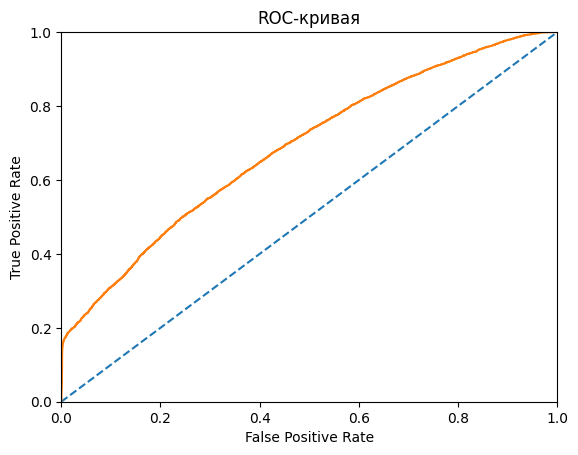

In [259]:
metrics(target_valid, model_lr.predict(features_ohe_slr_valid), model_lr.predict_proba(features_ohe_slr_valid))

### Decision Tree

In [260]:
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=10,
                                min_samples_leaf = 2, class_weight='balanced')

start_time_dt = time()

model_dt.fit(features_ohe_slr_train, target_train)

end_time_dt = time()

dt_model_time_fit = (end_time_dt-start_time_dt) / 60

In [261]:
print('Время обучение модели: {0:.5f} сек.'. format(dt_model_time_fit))

Время обучение модели: 0.00449 сек.


In [262]:
start_time_dt = time()
predicted = model_dt.predict(features_ohe_slr_train)
end_time_dt = time()

dt_model_time_predict = (end_time_dt-start_time_dt) / 60

In [263]:
print('Время прогнозирования модели: {0:.5f} сек.'. format(dt_model_time_predict))

Время прогнозирования модели: 0.00030 сек.


Матрица ошибок
[[7881 2616]
 [4329 4849]]
F1-score: 0.5827074445712912
AUC-ROC: 0.7084772563041547


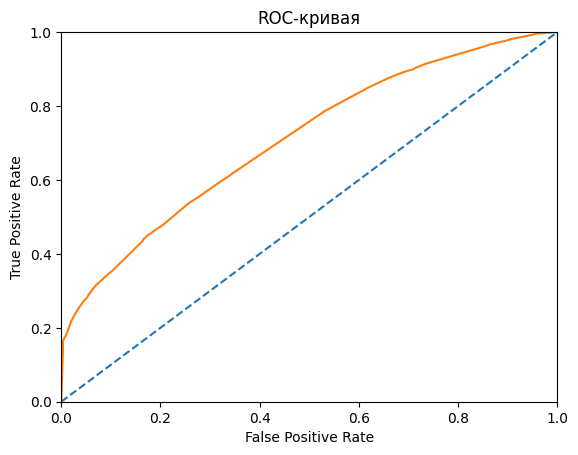

In [264]:
metrics(target_valid, model_dt.predict(features_ohe_slr_valid), model_dt.predict_proba(features_ohe_slr_valid))

### CatBoost

In [265]:
cat_features = features_train.select_dtypes(include='category').columns.to_list()

In [267]:
start_time_cat = time()
cat_model = CatBoostClassifier(loss_function='Logloss',
                                      depth=10,
                                      learning_rate=0.1,
                                      random_state=RANDOM_STATE,
                                      task_type="GPU",
                                      cat_features=cat_features,
                                      early_stopping_rounds=50,
                                      ).fit(features_train, target_train,
                                            plot=True, verbose=True,
                                            eval_set=(features_valid, target_valid))
end_time_cat = time()

cat_model_time_fit = (end_time_cat-start_time_cat) / 60

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6491346	test: 0.6497945	best: 0.6497945 (0)	total: 114ms	remaining: 1m 53s
1:	learn: 0.6183131	test: 0.6197998	best: 0.6197998 (1)	total: 251ms	remaining: 2m 5s
2:	learn: 0.5955894	test: 0.5975780	best: 0.5975780 (2)	total: 387ms	remaining: 2m 8s
3:	learn: 0.5797505	test: 0.5822535	best: 0.5822535 (3)	total: 614ms	remaining: 2m 32s
4:	learn: 0.5676676	test: 0.5705237	best: 0.5705237 (4)	total: 939ms	remaining: 3m 6s
5:	learn: 0.5581368	test: 0.5612779	best: 0.5612779 (5)	total: 1.07s	remaining: 2m 56s
6:	learn: 0.5509336	test: 0.5543380	best: 0.5543380 (6)	total: 1.16s	remaining: 2m 43s
7:	learn: 0.5455715	test: 0.5490913	best: 0.5490913 (7)	total: 1.25s	remaining: 2m 35s
8:	learn: 0.5405365	test: 0.5445516	best: 0.5445516 (8)	total: 1.42s	remaining: 2m 36s
9:	learn: 0.5370822	test: 0.5413282	best: 0.5413282 (9)	total: 1.61s	remaining: 2m 39s
10:	learn: 0.5340597	test: 0.5386778	best: 0.5386778 (10)	total: 1.86s	remaining: 2m 47s
11:	learn: 0.5312010	test: 0.5361677	best: 0

In [268]:
print('Время обучение модели: {0:.5f} сек.'. format(cat_model_time_fit))

Время обучение модели: 0.45111 сек.


In [269]:
start_time_lr = time()
predicted = cat_model.predict(features_train)
end_time_lr = time()

cat_model_time_predict = (end_time_lr-start_time_lr) / 60

In [270]:
print('Время прогнозирования модели: {0:.5f} сек.'. format(cat_model_time_predict))

Время прогнозирования модели: 0.00161 сек.


Матрица ошибок
[[9019 1478]
 [4152 5026]]
F1-score: 0.6409896696849892
AUC-ROC: 0.7968200110220451


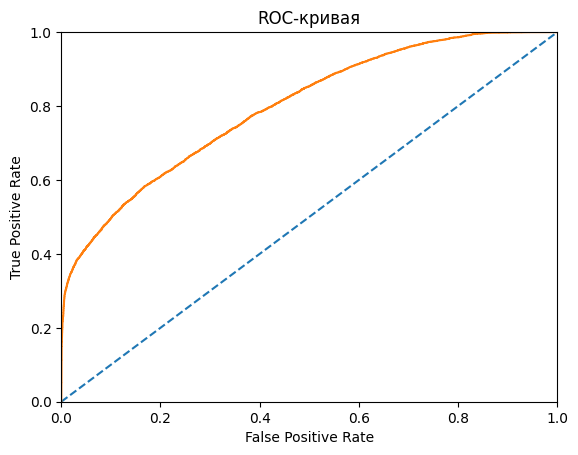

In [271]:
metrics(target_valid, cat_model.predict(features_valid), cat_model.predict_proba(features_valid))

**Выводы**

Были рассмотрены три модели `LogisticRegression`, `DecisionTreeClassifier` и `CatBoostClassifier`.

По результатам метрик была выбрана модель CatBoost.

In [272]:
results = {
    'Model' : ['LogisticRegression', 'DecisionTreeClassifier', 'CatBoostClassifier'],
    'Time Fit, sec' : pd.Series([lr_model_time_fit, dt_model_time_fit, cat_model_time_fit]),
    'Time Pred' :pd.Series([lr_model_time_predict, dt_model_time_predict, cat_model_time_predict]),
    'F1' :pd.Series([0.59, 0.58, 0.64]),
    'AUC-ROC' :pd.Series([0.68,0.70, 0.79])
    }
display(pd.DataFrame(results))

,Model,"Time Fit, sec",Time Pred,F1,AUC-ROC
0,LogisticRegression,0.018337,0.000150,0.59,0.68
1,DecisionTreeClassifier,0.004495,0.000300,0.58,0.70
2,CatBoostClassifier,0.451114,0.001608,0.64,0.79


# Оптимизация гипперпараметров и обучение лучшей модели

Воспользуемся библиотекой optuna для подбора оптимальных гипперпараметров для обучения финальной модели

In [275]:
def objective(trial):
    params = {
        "iterations": 10000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 5, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 100),
        "task_type":"GPU",
        'early_stopping_rounds': 100
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(features_train, target_train, cat_features, eval_set=(features_valid, target_valid))
    predictions = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions)
    return f1

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best F1:', study.best_value)

Best hyperparameters: {'learning_rate': 0.009081480224991952, 'depth': 6, 'min_data_in_leaf': 73}
Best F1: 0.6785320364985461


In [277]:
params_opt = {'learning_rate': 0.07192169545191199, 'depth': 9, 'min_data_in_leaf': 52, 'early_stopping_rounds': 100, "iterations": 10000,"task_type":"GPU",}

In [279]:
cv_params = cat_model.get_params()
# cv_params.update(study.best_params)
cv_params.update(params_opt)

cat_model = CatBoostClassifier(**cv_params).fit(features_train, target_train,
                                            plot=True, verbose=True,
                                            eval_set=(features_valid, target_valid))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6608001	test: 0.6612794	best: 0.6612794 (0)	total: 125ms	remaining: 20m 53s
1:	learn: 0.6358514	test: 0.6367654	best: 0.6367654 (1)	total: 223ms	remaining: 18m 34s
2:	learn: 0.6156546	test: 0.6169248	best: 0.6169248 (2)	total: 323ms	remaining: 17m 55s
3:	learn: 0.5997181	test: 0.6013666	best: 0.6013666 (3)	total: 482ms	remaining: 20m 4s
4:	learn: 0.5880845	test: 0.5899979	best: 0.5899979 (4)	total: 619ms	remaining: 20m 37s
5:	learn: 0.5776726	test: 0.5797112	best: 0.5797112 (5)	total: 714ms	remaining: 19m 49s
6:	learn: 0.5702613	test: 0.5724512	best: 0.5724512 (6)	total: 923ms	remaining: 21m 57s
7:	learn: 0.5631804	test: 0.5656458	best: 0.5656458 (7)	total: 1.14s	remaining: 23m 48s
8:	learn: 0.5575346	test: 0.5599682	best: 0.5599682 (8)	total: 1.37s	remaining: 25m 22s
9:	learn: 0.5532627	test: 0.5557952	best: 0.5557952 (9)	total: 1.6s	remaining: 26m 42s
10:	learn: 0.5495782	test: 0.5520121	best: 0.5520121 (10)	total: 1.67s	remaining: 25m 18s
11:	learn: 0.5459437	test: 0.548

Матрица ошибок
[[8995 1502]
 [4094 5084]]
F1-score: 0.6450139558487693
AUC-ROC: 0.7974309680942575


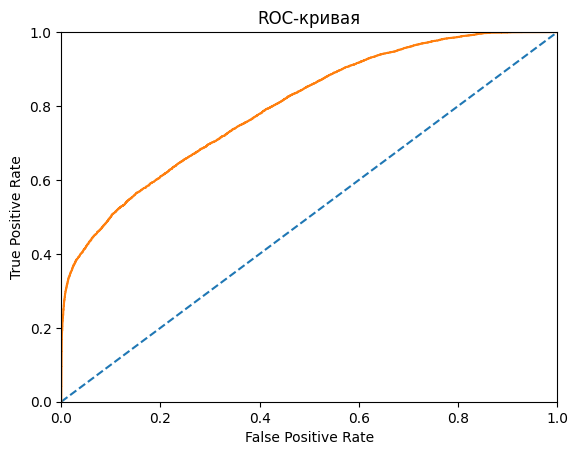

In [281]:
metrics(target_valid, cat_model.predict(features_valid), cat_model.predict_proba(features_valid))

Матрица ошибок
[[8925 1573]
 [4023 5154]]
F1-score: 0.6481388329979879
AUC-ROC: 0.794154905058998


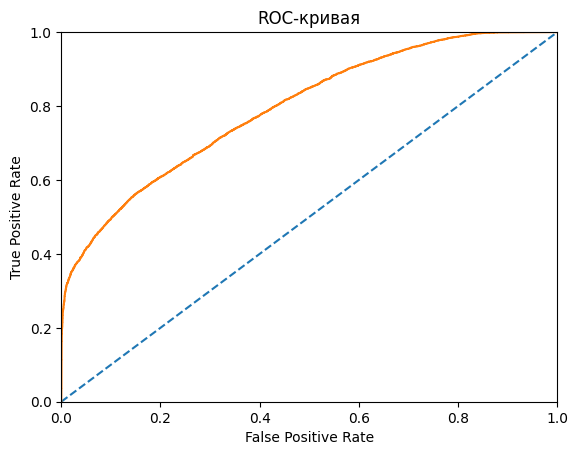

In [280]:
metrics(target_test, cat_model.predict(features_test), cat_model.predict_proba(features_test))

**Выводы**

По результатам обучения модели с оптимизированными гипперпараметрами, удалось добиться значений метрик на тестовой выборке


- F1 0.64
- AUC-ROC 0.79

# Важность признаков

Из результатов обучения модели CatBoost оценим, какие признаки по мнению модели были наиболее значимыми.

In [282]:
features_imp = cat_model.get_feature_importance(prettified=True)
features_imp

,Feature Id,Importances
0,party_count,19.851142
1,pcf_violation_category,15.490044
2,party_sobriety,13.894815
3,insurance_premium,11.379369
4,motor_vehicle_involved_with,4.983109
5,vehicle_age,4.355905
6,primary_collision_factor,4.050117
7,vehicle_type,3.961272
8,distance,2.775735
9,type_of_collision,2.533689


In [283]:
explainer = shap.TreeExplainer(cat_model)
shap_values=explainer.shap_values(Pool(features_train, target_train, cat_features=cat_features))

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[3,:], features_train.iloc[3,:])

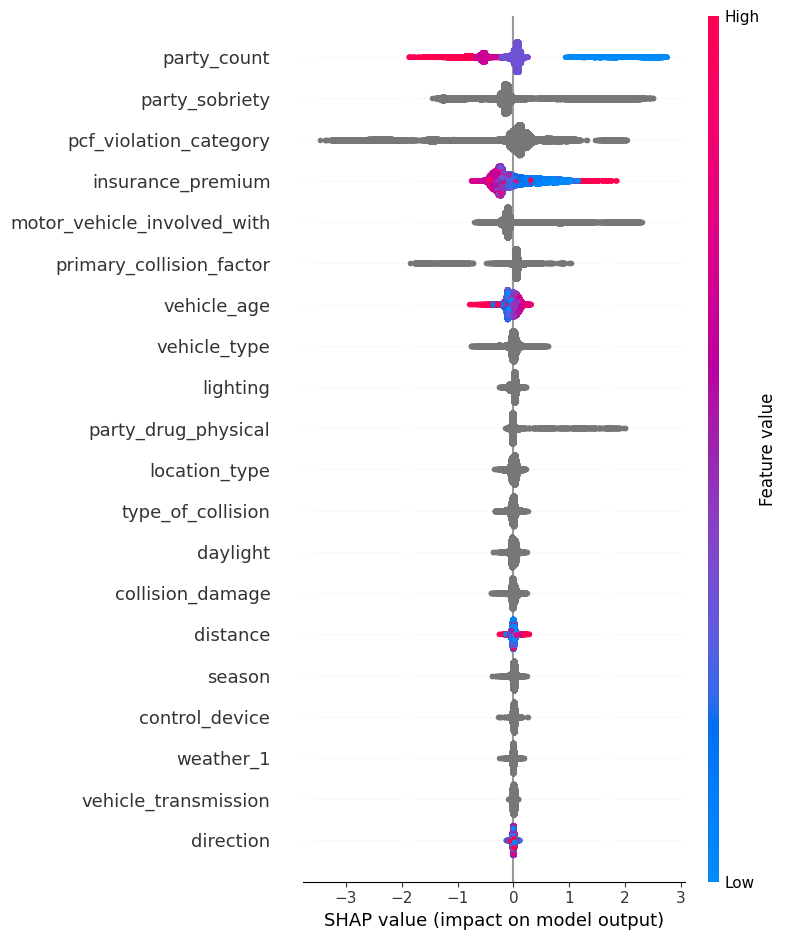

In [286]:
shap.summary_plot(shap_values, features_train)

Из всех возможных признаков в топ-3 модель выделила: количество участников проишествия, категория нарушения и трезвость участника ДТП. Рассмотрим корреляционную связь с ДТП на примере трезвости участника, для первых 500 прогнозов

In [293]:
features_train_small = features_train.iloc[0:500]
shap_small = shap_values[:500]
shap.force_plot(explainer.expected_value, shap_small, features_train_small)

Как можно видеть из графика, на результат работы модели сильно влиял факт того находится ли участник движение в трезвом состоянии.

Тоже самое можно сказать и о количестве участнимков нарушений, где при значении 1, очевидно прогнозируется, что водитель виновен и чаще не виновен если участников больше 2.

# Заключение

Целью проекта было создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Заказчику было важно:

- тип виновника — только машина (car);
- любым повреждениям транспортного средства, кроме типа SCRATCH (царапина);
- ограничиться данными за 2012 год — они самые свежие;
- учесть фактор возраста автомобиля.

Выполненые задачи:
- Первичный анализ таблиц;
- Cтатистический анализ факторов ДТП;
- Оценка водительского риска и EDA;
- Подготовка признаков и построение базовых моделей;
- Оптимизация гипперпараметров и обучение лучшей модели;
- Важность признаков.

**Первичный анализ таблиц**

Количество таблиц сопадало с заявленым, однако во всех таблицах имелись пропуски в данных и типы данных не соответсвовали заявленым. Связующая таблица case_ids не соответствовала завяленой архитектуре. Записи в таблицах `collisions` и `parties` несогласовались с описанием таблиц. Связующая таблица в столбце `db_year` содержит только одно уникальное значение 2021 года, что он означает не известно, но скорее всего это год создания схемы.

В данных содержится информация связанная исключительно с ДТП, но нет данных которые бы относились к благоприятной поездки, при обучении модель будет всегда смещаться в сторону ДТП из-за дисбаланса.

Общий ключ для всех таблиц - case_id

**Cтатистический анализ факторов ДТП**

Наиболее опасными сезонами является весна и зима, это можно связать с сильным изменением погодных условий, таких как: температура, давление, количество осадков, скорость ветра. Можно предположить, что все эти параметры влияют на дорожное покрытие и видимость для автомобилиста, что повишает риск ДТП, что и видно на гистрограмме.

Для команды аналитиков были подготовлены аналитические задачи:
- Определить распределение участников проишествия по типу;
- Определить корреляцию между основным фактором аварии и суммой страховки;
- Существует ли зависимость параметров автомобиля с суммой страховки;
- Есть ли связь с состоянием дороги и временем года;
- Оценить взудите диссперсии параметров в таблице "информация о происшествиях", существуют ли линейно дублирующие параметры в таблице;
- Оценить серьезность ущерба в зависимости от трезвости водителя.

Преведены примеры решения некоторых из них, по результатам которых стало ясно, что:

- Наиболее опасными сезонами является весна и зима, это можно связать с сильным изменением погодных условий, таких как: температура, давление, количество осадков, скорость ветра. Можно предположить, что все эти параметры влияют на дорожное покрытие и видимость для автомобилиста, что повишает риск ДТП, что и видно на гистрограмме.
- Наиболее частым участником проишествия является другой автомобиль, на втором месте дорожные знаки.
- Из анализа коррелляции и статистической значимости, можно сказать, что размер страховки не полностью, но в том числе зависит от типа кузова автомобиля, анализ показал, что по количеству аварий лидирующие позиции занимают тип кузова купе и седан они же имеют самые большие страховые взносы.

**Оценка водительского риска и EDA**

Подготовлены данные согласно требованию заказчика.

- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.

Также добавлен новый столбец указывающий на время года в которое было совершено ДТП и время суток основанное на значениях времени.

Для большинства данных с пропусками, было выполнено заполнение этих пропусков в зависимости от специфики признака, для данных объем пропуском которых составлял менее 1.5% было принято решение об удалении пустых строк.

**Подготовка признаков и построение базовых моделей**

Были рассмотрены три модели `LogisticRegression`, `DecisionTreeClassifier` и `CatBoostClassifier`.
Для первых двух моделей данные были энкодированы технологией OHE и выполнено масштабирование, для CatBoost это делать не нужно, по инструкции разработчиков.
Выбранные модели оценивались по нескольким показателям: время обучения модели, время прогназирование модели, матрица ошибок, значение метрики F1 и площади под ROC-кривой.

По результатам метрик из таблицы была выбрана модель CatBoost.


In [294]:
results = {
    'Model' : ['LogisticRegression', 'DecisionTreeClassifier', 'CatBoostClassifier'],
    'Time Fit, sec' : pd.Series([lr_model_time_fit, dt_model_time_fit, cat_model_time_fit]),
    'Time Pred' :pd.Series([lr_model_time_predict, dt_model_time_predict, cat_model_time_predict]),
    'F1' :pd.Series([0.59, 0.58, 0.64]),
    'AUC-ROC' :pd.Series([0.68,0.70, 0.79])
    }
display(pd.DataFrame(results))

,Model,"Time Fit, sec",Time Pred,F1,AUC-ROC
0,LogisticRegression,0.018337,0.000150,0.59,0.68
1,DecisionTreeClassifier,0.004495,0.000300,0.58,0.70
2,CatBoostClassifier,0.451114,0.001608,0.64,0.79


**Оптимизация гипперпараметров и обучение лучшей модели**

Для оптимизации гипперпараметров использовалась библиотека optuna. По результатам обучения модели с новыми гипперпараметрами удалось добиться на тестовой выборке значений 

- F1 0.64
- AUC-ROC 0.79

А матрица ошибок имела вид:

- |8925|1573|
- |4023|5154|

**Важность признаков**

Из всех возможных признаков в топ-3 модель выделила: количество участников проишествия, категория нарушения и трезвость участника ДТП.


**Заключение**

На основании предоставленных данных невозможно построение системы оценки риска ДТП. Данные отображают только одну категорию - "Водители попавшие в ДТП", второй категории - "Водители не попавшие в ДТП" нет совсем. Наша сисетма обучаясь на данных в которых 100% дисбаланс классов учится предказывать, что все поездки закончатся ДТП.

